This notebook is related to a series of other notebooks

- [Data preprocessing](https://www.kaggle.com/code/db0boy/lending-club-loan-data-cleared-preparation) 

- [Adding new features and splitting data](https://www.kaggle.com/code/db0boy/credit-scoring-data-processing)

- Constructing interpreted logistic regression

- [Building uninterpreted models](https://www.kaggle.com/code/db0boy/credit-scoring-uninterpretable-models)

Also, all notebooks are linked to [this repository](https://github.com/boyfws/Predicting-default)

# Loading files from repository

In [1]:
!git clone --depth 1 https://github.com/boyfws/Predicting-default

Cloning into 'Predicting-default'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 0), reused 16 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 3.24 MiB | 26.31 MiB/s, done.


In [2]:
!pip install -r /kaggle/working/Predicting-default/requirements.txt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.6/343.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install ortools==9.7.2996 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.7 MB/s eta 0:00:00


# Imports 

## Base

In [4]:
import sys
import os
import random
from dataclasses import dataclass
import warnings

In [5]:
import pandas as pd
import numpy as np

from pathlib import Path

## Modules from repo

In [6]:
sys.path.append("/kaggle/working/Predicting-default")
from Validator import Validator
from binning import Binner
from utils import classification_report
from ExpectedIncome import IncomePredictor

## sklearn

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, ClassifierMixin

## Visualization 

In [8]:
import matplotlib.pyplot as plt
from IPython.display import display


## Other

In [9]:
from catboost import CatBoostClassifier

# Config 

## Config class 

In [10]:
@dataclass(frozen=True)
class Config:
    seed = 42
    data_path = Path("/kaggle/input/credit-scoring-data-processing")
    missing_label = "__MISSING__"
    n_jobs = -1

## Configure env

In [11]:
os.environ["PYTHONWARNINGS"] = "ignore"
warnings.filterwarnings("ignore")

random.seed(Config.seed)  # Python
np.random.seed(Config.seed)  # NumPy
os.environ["PYTHONHASHSEED"] = str(Config.seed)

# Loading data 

In [12]:
for el in ["train", "test", "val"]:
    globals()[f"X_{el}"] = pd.read_csv(Config.data_path / f"X_{el}.csv").drop("emp_title", axis=1)
    globals()[f"y_{el}"] = np.load(Config.data_path / f"y_{el}.npy")

# Binner params

In [13]:
PARAMS ={
    "emp_length": dict(
        dtype="categorical",
        min_prebin_size=0.03
    ),
    "home_ownership_status": dict(
        dtype="categorical",
        min_prebin_size=0.03
    ),
    "verification_status": dict(
        dtype="categorical",
        min_prebin_size=0.05
    ),
    "loan_purpose": dict(
        dtype="categorical",
        min_prebin_size=0.015
    ),
    "addr_state": dict(
        dtype="categorical",
        min_prebin_size=0.01
    ),
    "initial_list_status": dict(
        dtype="categorical"
    ),   
    "disbursement_method": dict(
        dtype="categorical"
    ),
    "issue_date_month": dict(
        dtype="categorical"
    ),
    "region_code": dict(
        dtype="categorical"
    ), 
    "earliest_cr_line_month": dict(
        dtype="categorical"
    ),
    "earliest_cr_line_full": dict(
        dtype="categorical"
    ),
    
}

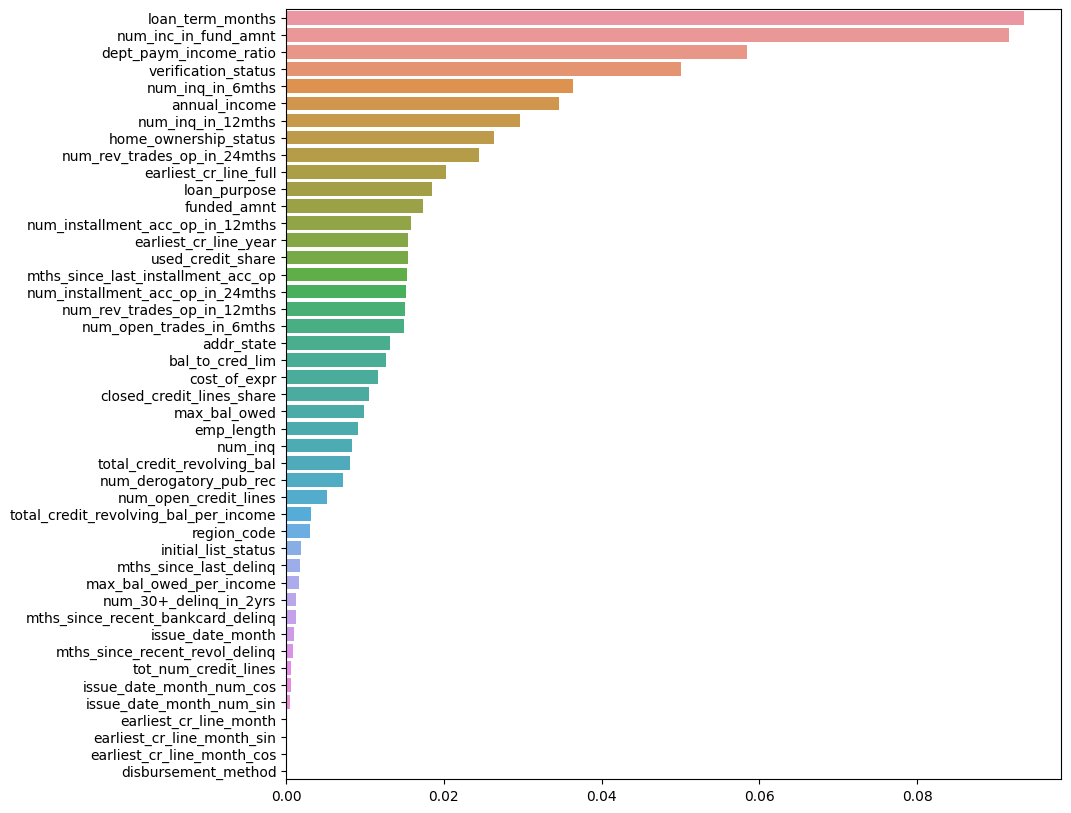

In [14]:
binner = Binner(PARAMS)

binner.fit(X_train, y_train)
binner.plot_iv()

# Validator

In [15]:
validator = Validator(
    plot_graphs=True,
    figsize=(14, 14),
    n_jobs=Config.n_jobs,
) 

# Baseline

Let's build the simplest model by binning and find the optimal threshold 

In [16]:
pipeline = Pipeline([
    ('binner', Binner(PARAMS)),  
    ('classifier', SGDClassifier(
        loss='log_loss', 
        penalty='l2',     
        max_iter=1000,
        tol=1e-3,
        random_state=Config.seed,
        learning_rate='optimal',
        verbose=1
    ))
])

pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict_proba(X_train)[:, 1]

-- Epoch 1
Norm: 3.62, NNZs: 44, Bias: -1.507605, T: 1312368, Avg. loss: 0.435803
Total training time: 0.74 seconds.
-- Epoch 2
Norm: 3.60, NNZs: 44, Bias: -1.512301, T: 2624736, Avg. loss: 0.431961
Total training time: 1.45 seconds.
-- Epoch 3
Norm: 3.54, NNZs: 44, Bias: -1.540535, T: 3937104, Avg. loss: 0.431814
Total training time: 2.15 seconds.
-- Epoch 4
Norm: 3.53, NNZs: 44, Bias: -1.531186, T: 5249472, Avg. loss: 0.431760
Total training time: 2.93 seconds.
-- Epoch 5
Norm: 3.50, NNZs: 44, Bias: -1.593204, T: 6561840, Avg. loss: 0.431738
Total training time: 3.67 seconds.
-- Epoch 6
Norm: 3.55, NNZs: 44, Bias: -1.483139, T: 7874208, Avg. loss: 0.431709
Total training time: 4.34 seconds.
-- Epoch 7
Norm: 3.55, NNZs: 44, Bias: -1.567833, T: 9186576, Avg. loss: 0.431690
Total training time: 5.02 seconds.
Convergence after 7 epochs took 5.02 seconds


## Train classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.673
Brier Score 0.134
Divergence Score 0.367

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



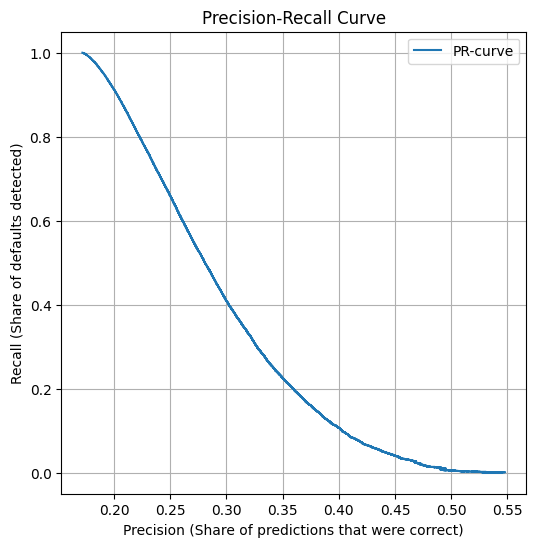


--------------------------------------------------
F1 Curve
--------------------------------------------------



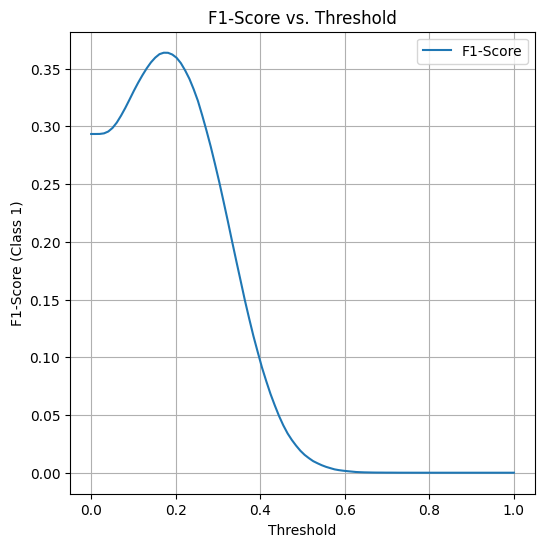


--------------------------------------------------
Calibration Curve
--------------------------------------------------



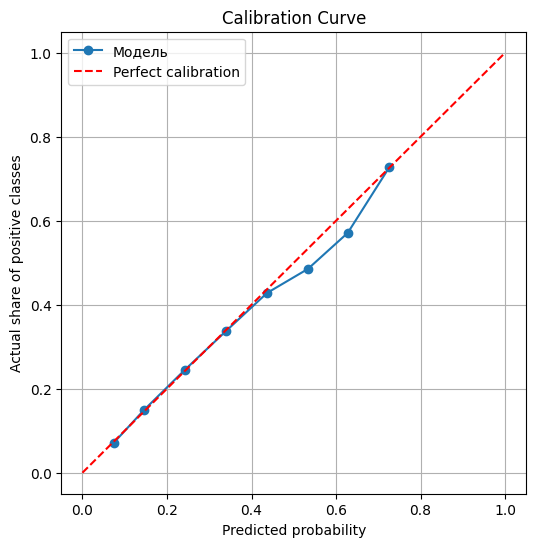

In [17]:
classification_report(y_train, y_pred_train, figsize=(6, 6))

## Test classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.668
Brier Score 0.093
Divergence Score 0.333

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



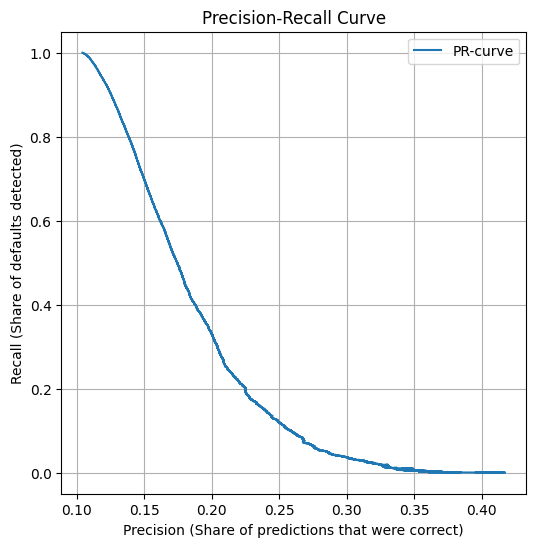


--------------------------------------------------
F1 Curve
--------------------------------------------------



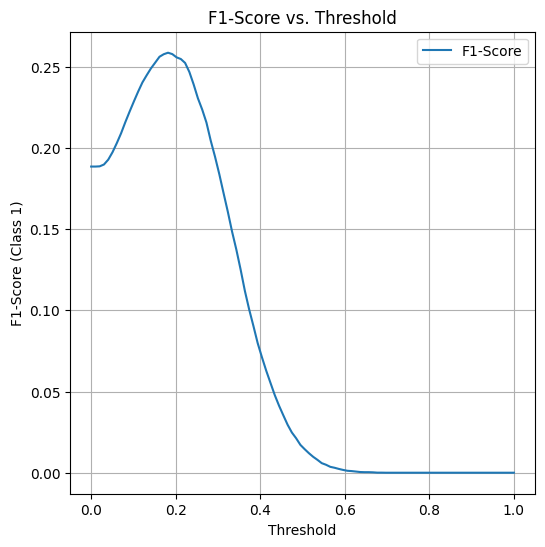


--------------------------------------------------
Calibration Curve
--------------------------------------------------



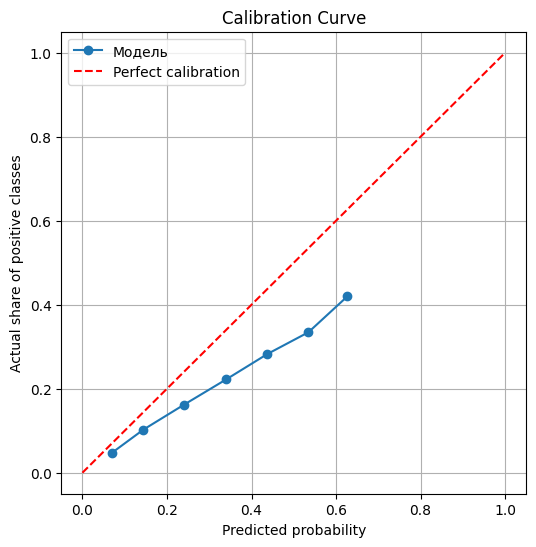

In [18]:
classification_report(y_test, pipeline.predict_proba(X_test)[:, 1], figsize=(6, 6))

## Val classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.656
Brier Score 0.046
Divergence Score 0.280

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



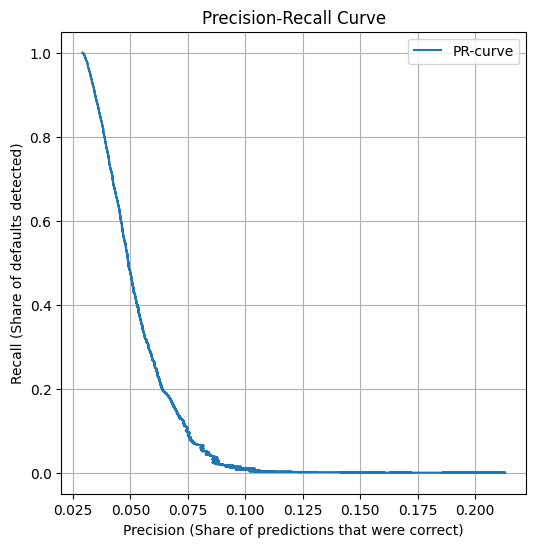


--------------------------------------------------
F1 Curve
--------------------------------------------------



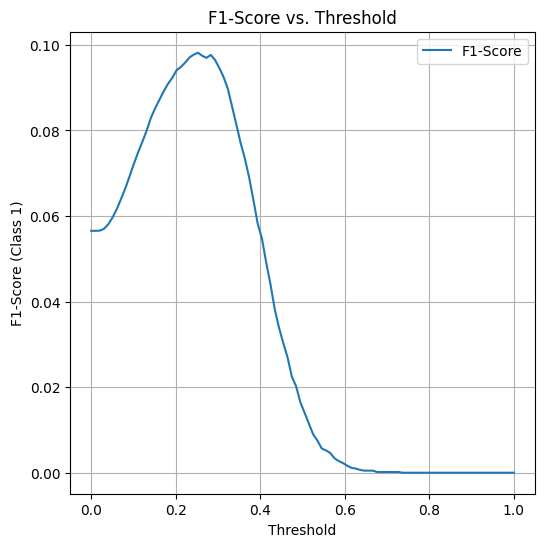


--------------------------------------------------
Calibration Curve
--------------------------------------------------



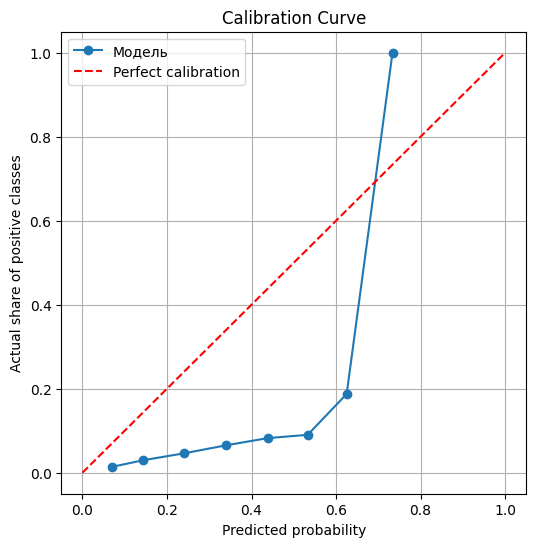

In [19]:
classification_report(y_val, pipeline.predict_proba(X_val)[:, 1], figsize=(6, 6))

## Validation

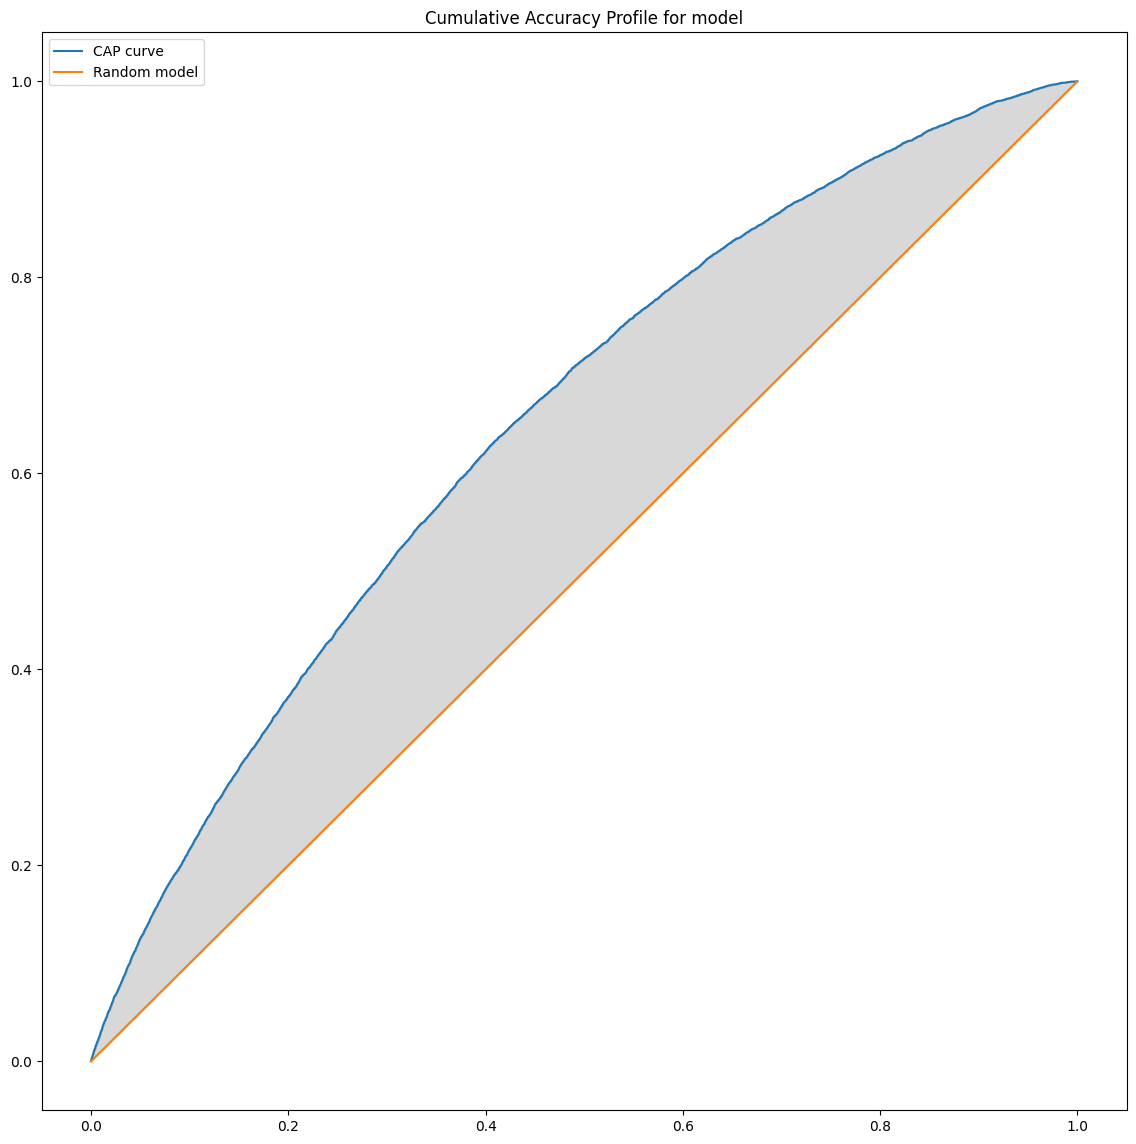

╭─────────────────────────────────────────────── General Gini test ───────────────────────────────────────────────╮
│ ⚠️ Intermediate result with gini 0.30                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

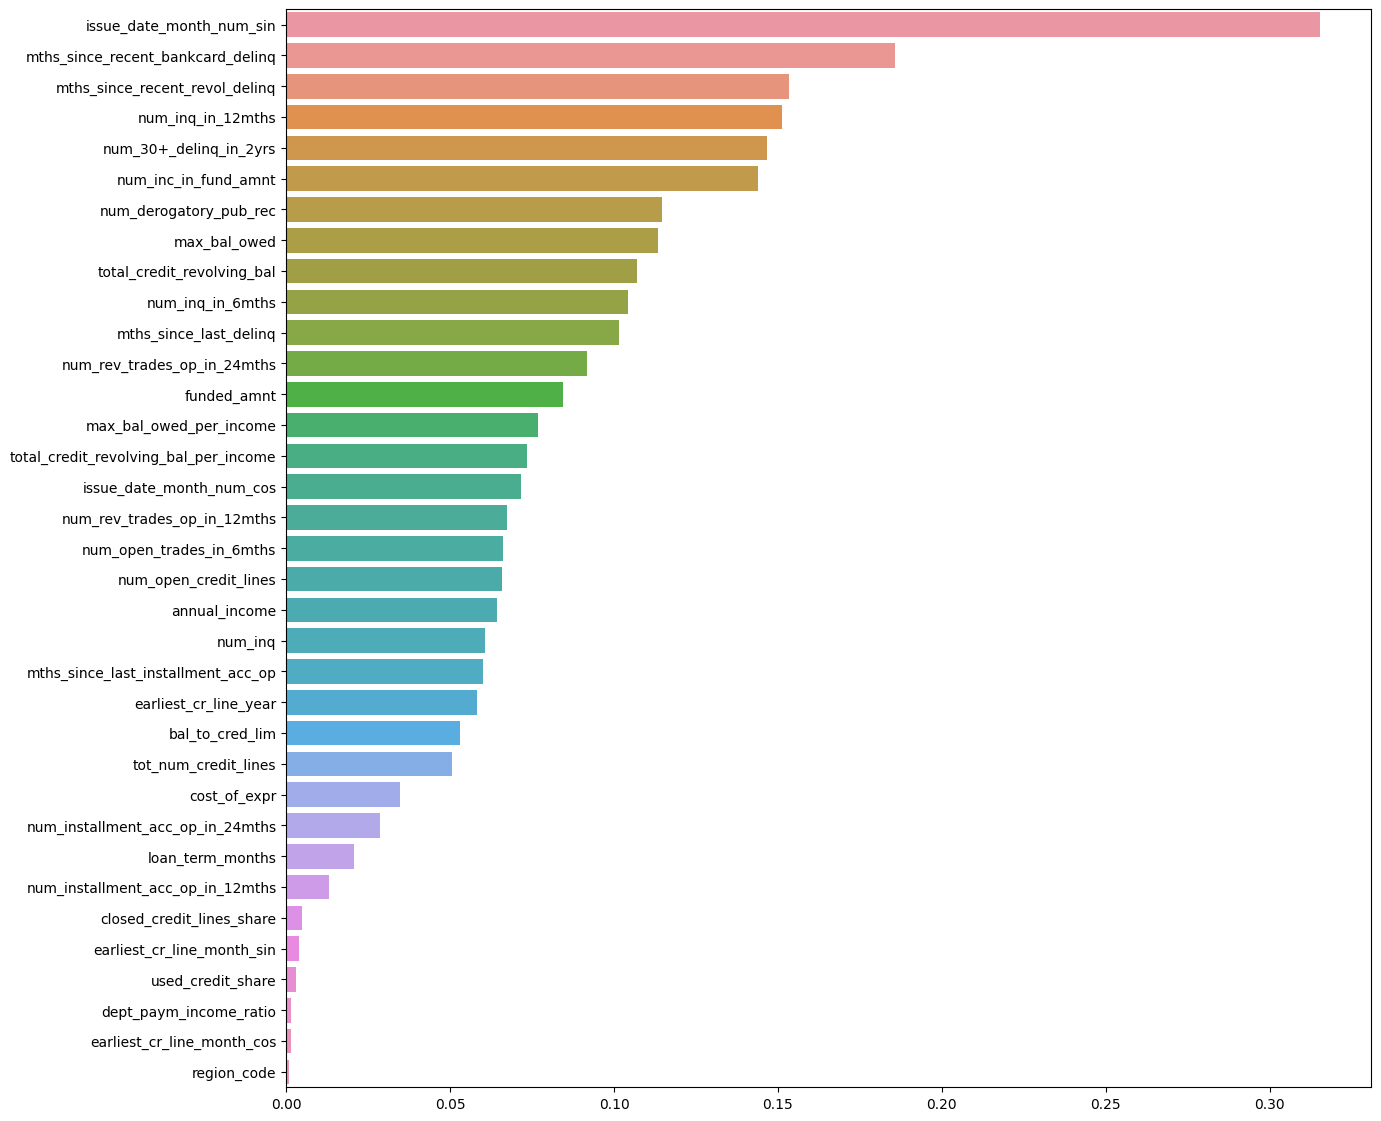

╭─────────────────────────────────────────────── Feature Gini test ───────────────────────────────────────────────╮
│ ❌ Test failed with red, yellow, green shares 0.29, 0.40, 0.31                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

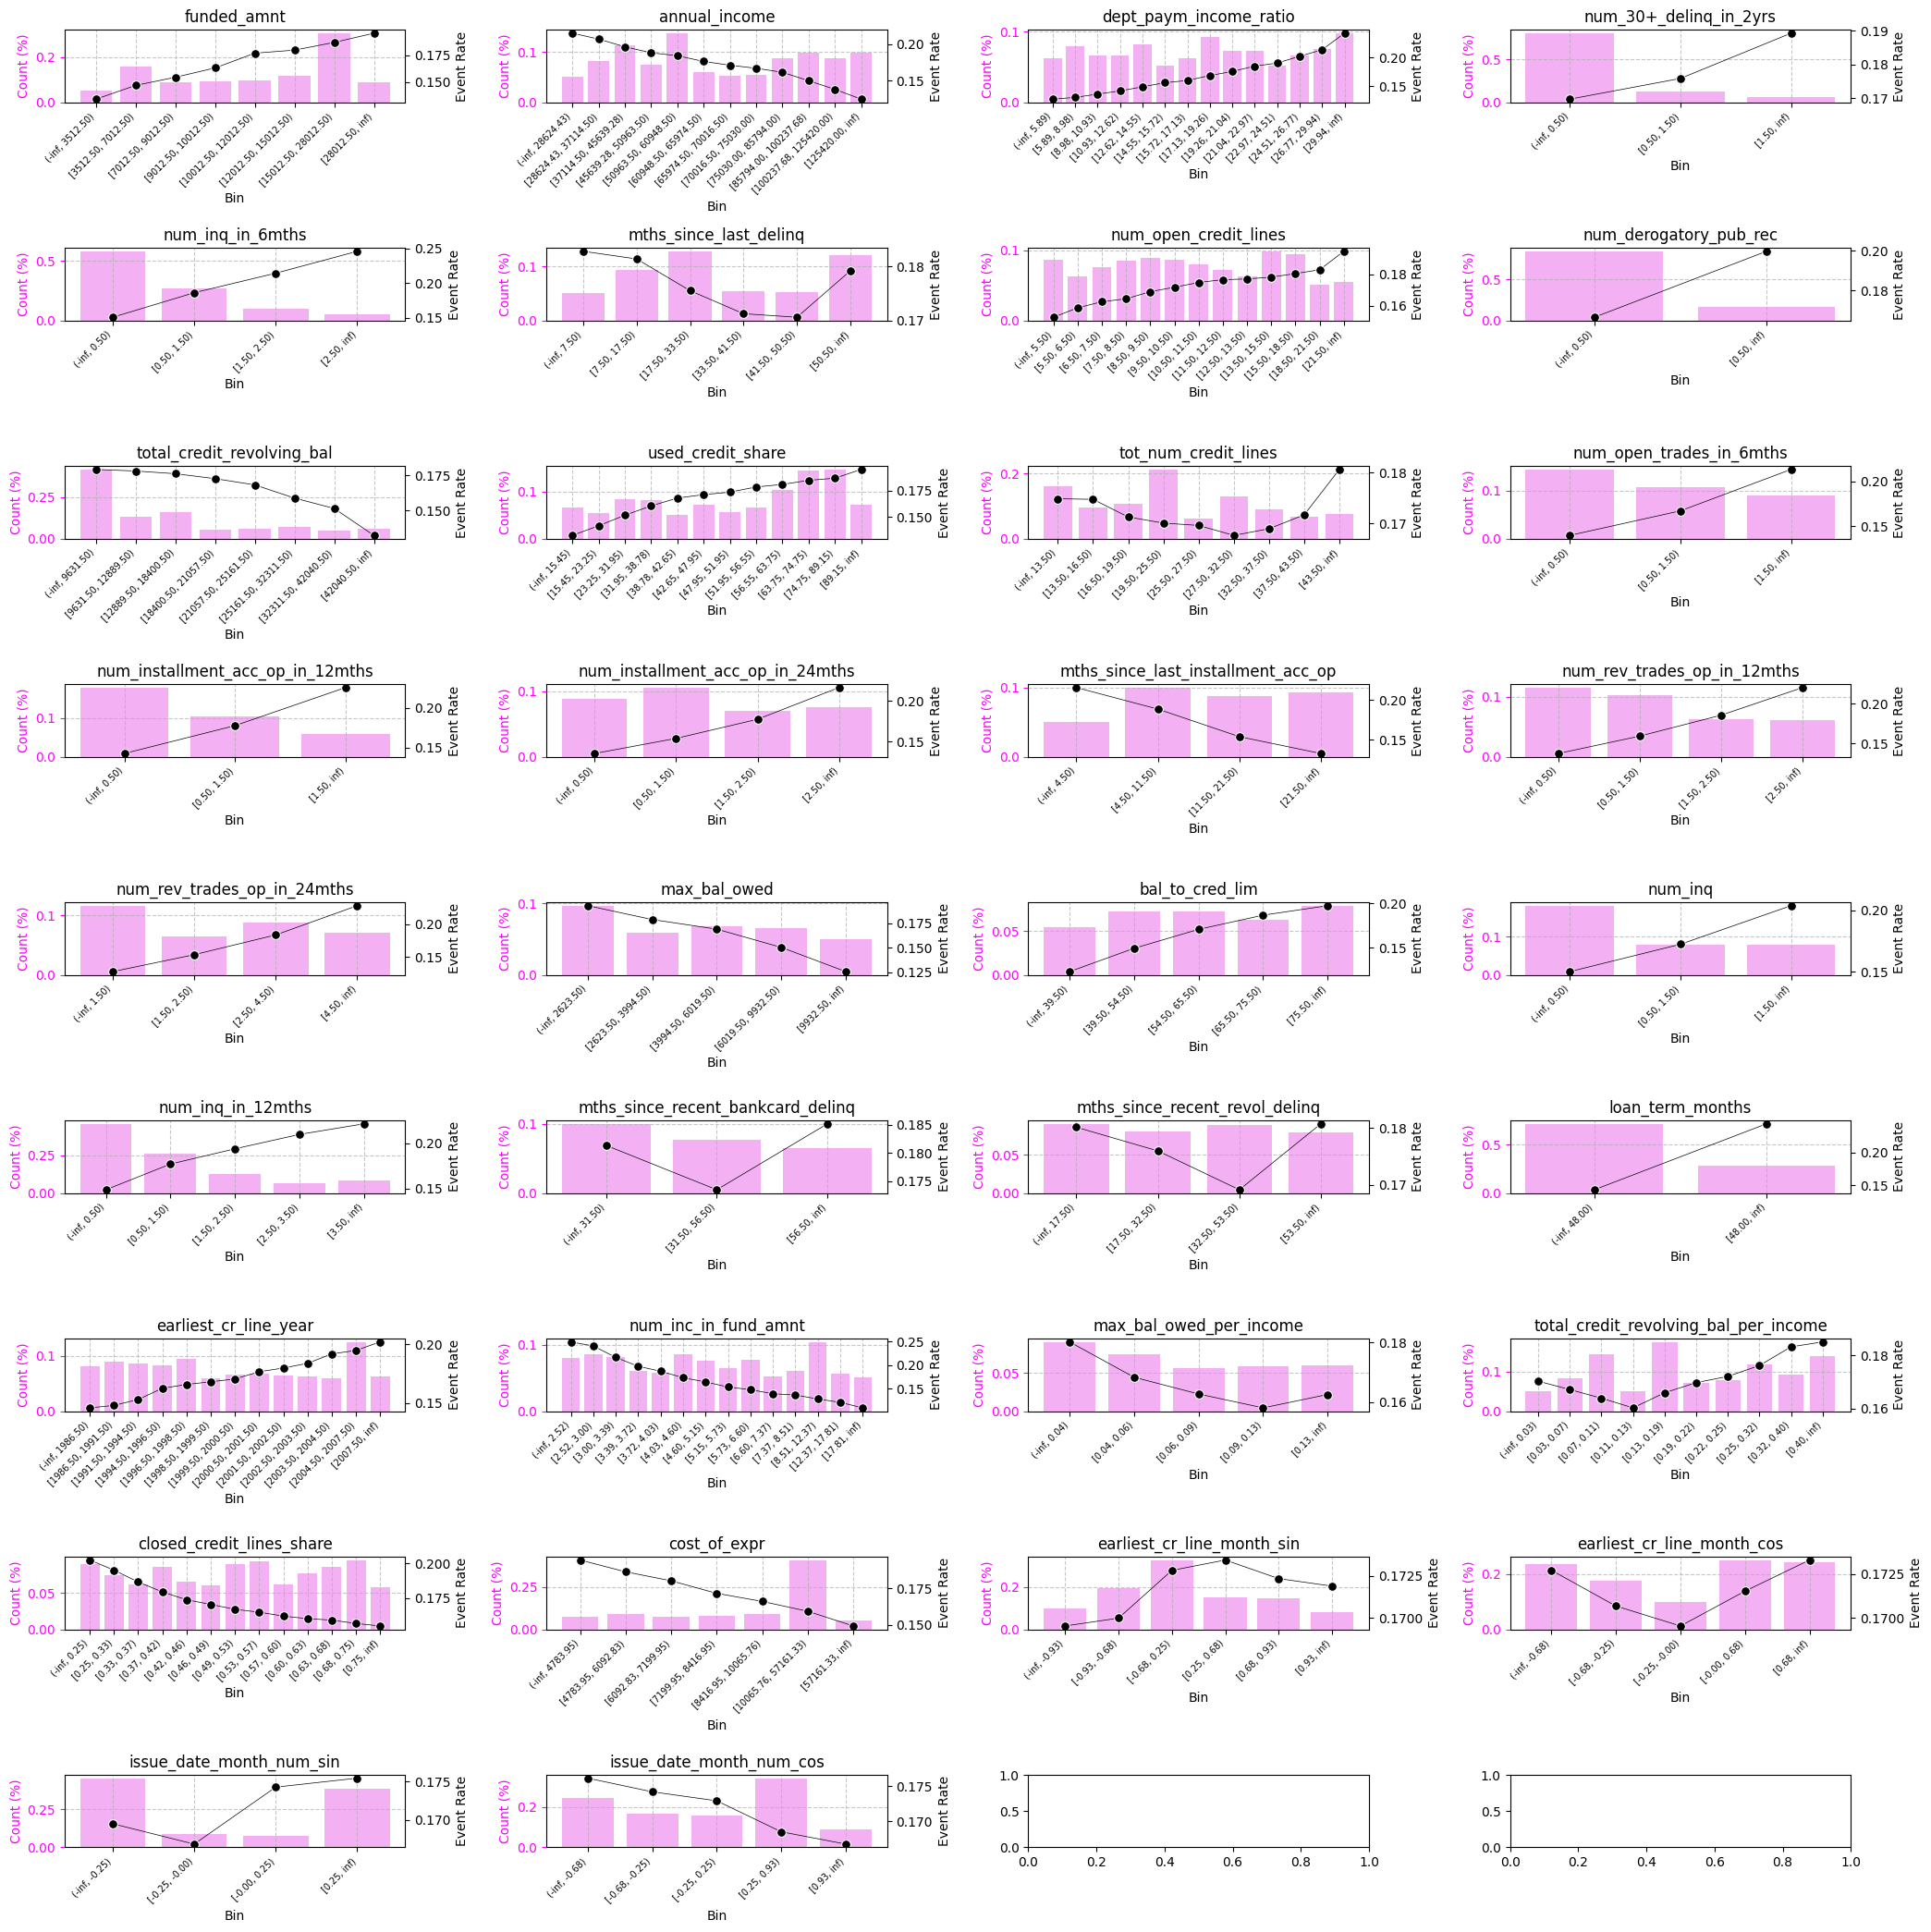

╭───────────────────────────────────────────────── Binning test ──────────────────────────────────────────────────╮
│ ⚠️ Intermediate result with red, yellow, green shares 0.18, 0.62, 0.21                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

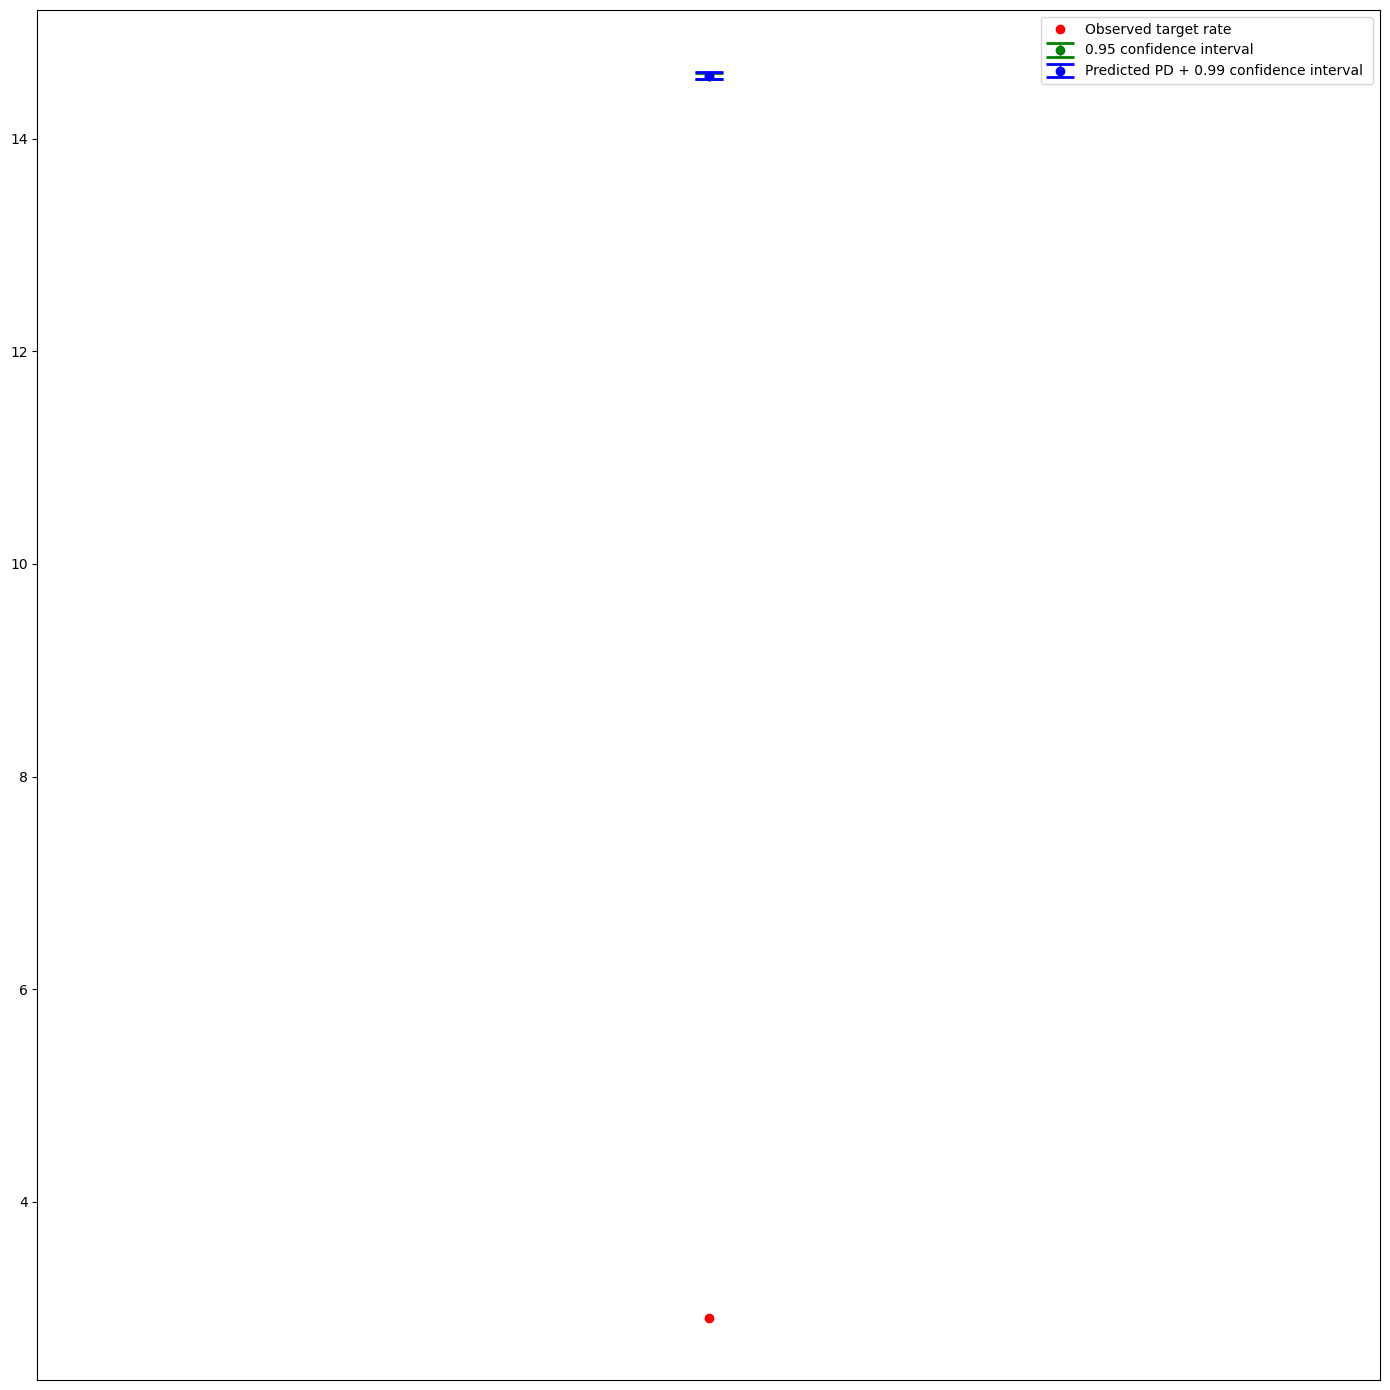

╭─────────────────────────────────────────────── Target Rate test ────────────────────────────────────────────────╮
│ ❌ Test failed with share 401.63%                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

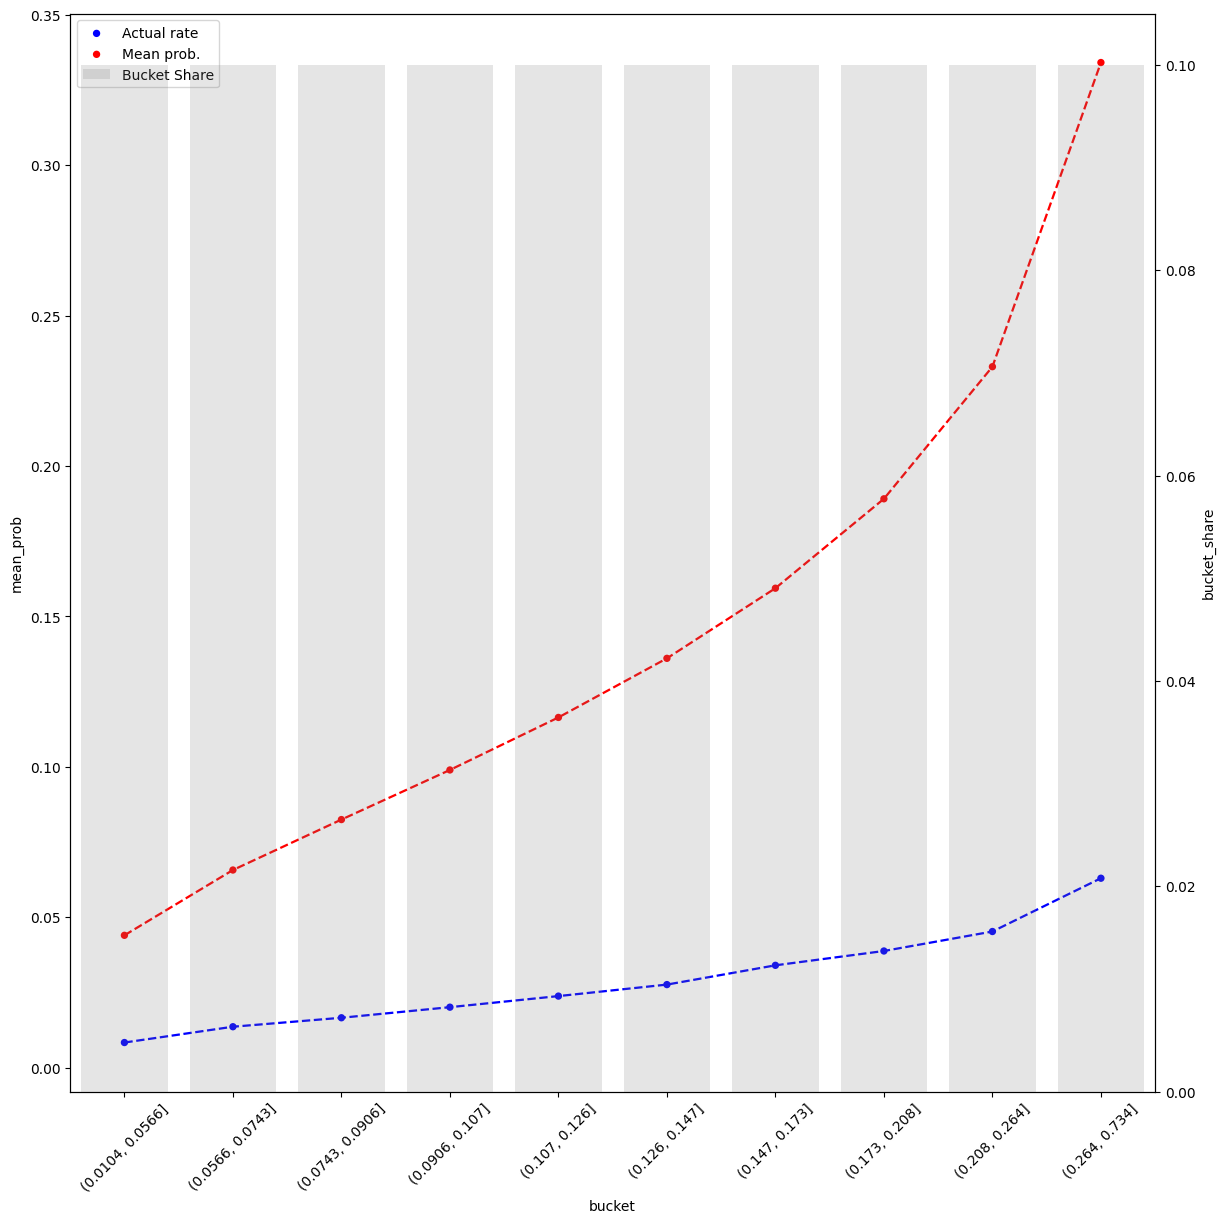

╭──────────────────────────────────────────── Calibration Curve test ─────────────────────────────────────────────╮
│ ❌ Test failed                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

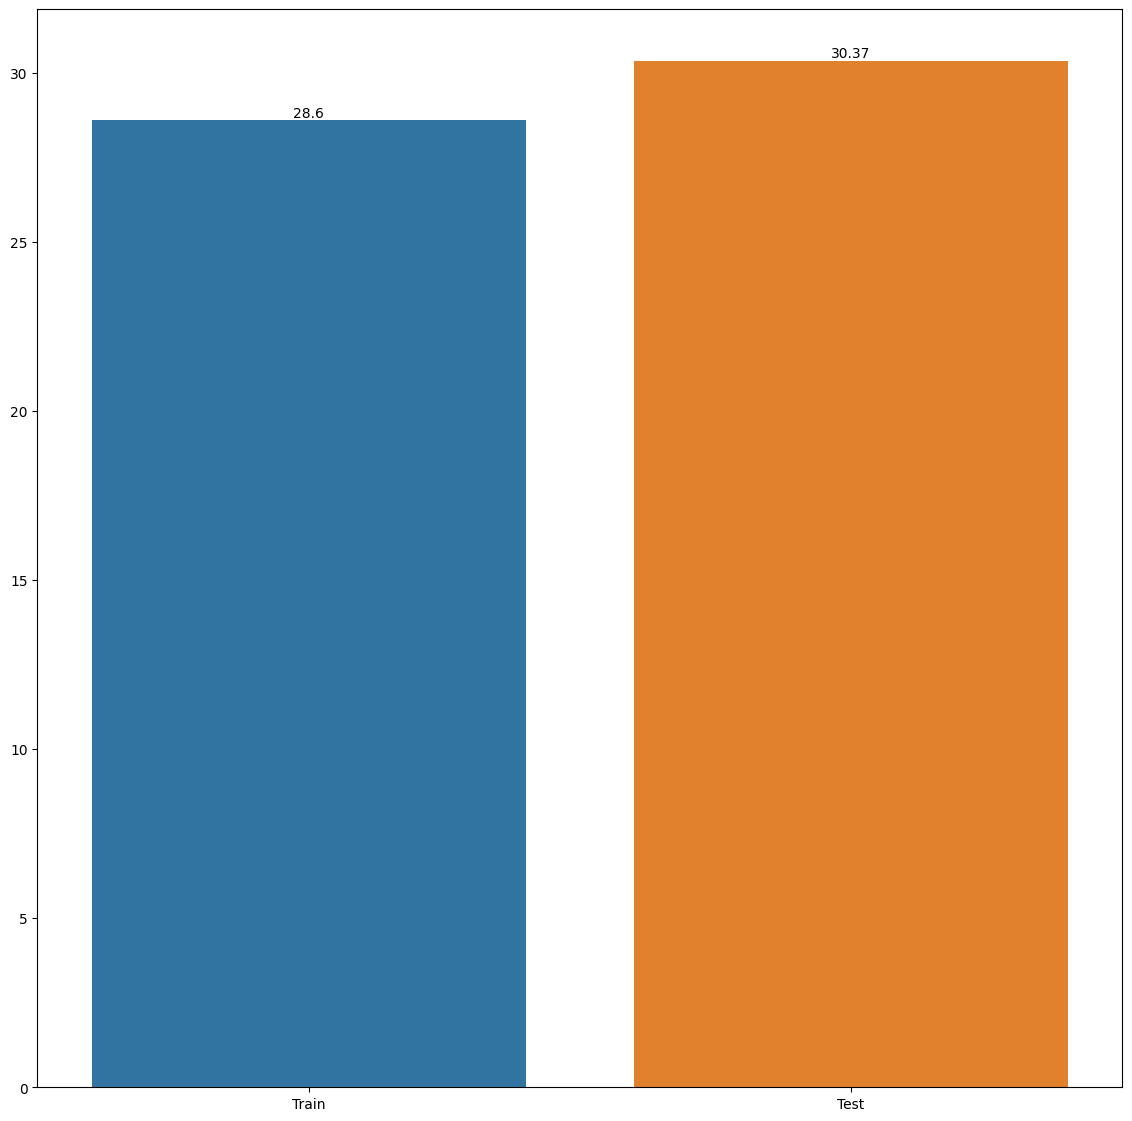

╭─────────────────────────────────────────────── Gini Change test ────────────────────────────────────────────────╮
│ ✅ Test passed with absolute and relative diffs: 1.77 p.p and 6.19%                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

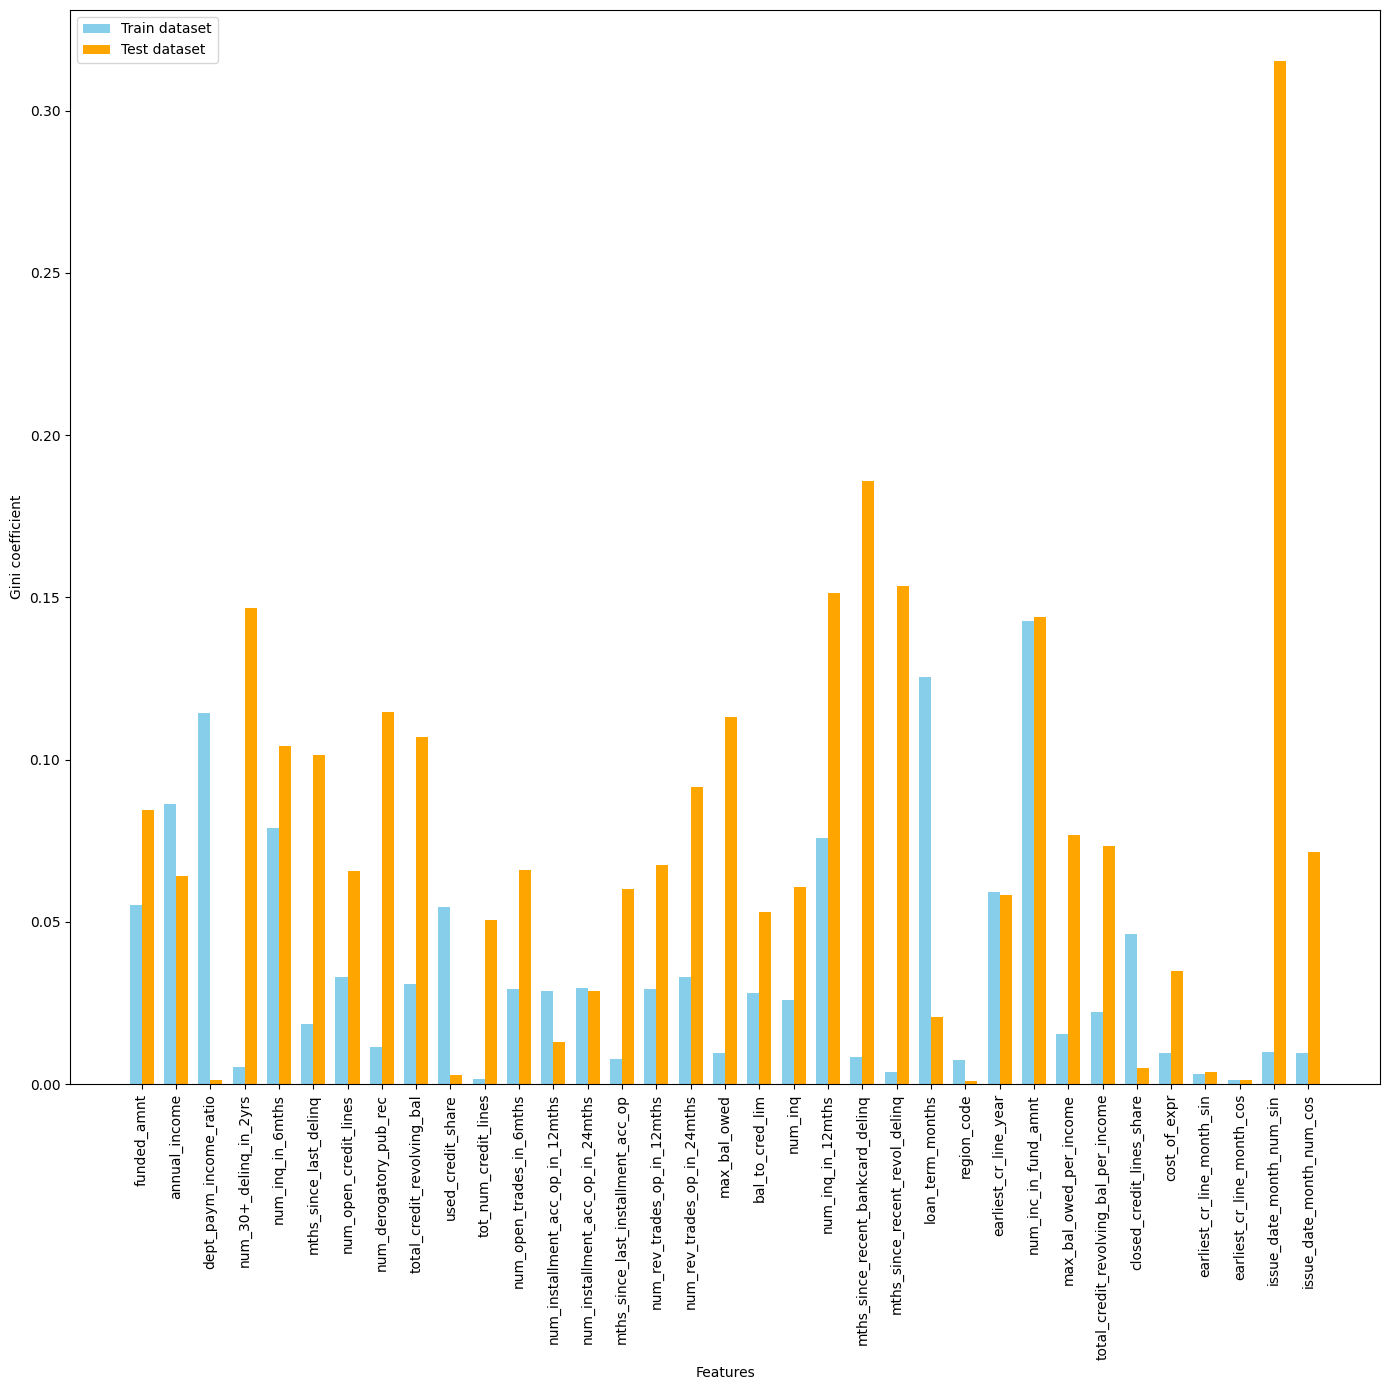

╭─────────────────────────────────────────── Features Gini Change test ───────────────────────────────────────────╮
│ ⚠️ Intermediate result with 0.00, 0.11, 0.89 shares for red, yellow, green scores                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── Final result ──────────────────────────────────────────────────╮
│ ❌ Validation failed                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [20]:
validator.validate(
    X_val,
    y_val,
    model=pipeline.named_steps.classifier,
    train_data=[X_train, y_train],
    binner=pipeline.named_steps.binner
)

# Removing bad features 

As we can see Feature Gini Test is not passed, so let's remove some of "bad" features, with low gini score 

## List of remaining features

In [21]:
good_features = [
    "issue_date_month_num_sin",
    "mths_since_recent_bankcard_delinq",
    "mths_since_recent_revol_delinq",
    "num_inq_in_12mths",
    "num_30+_delinq_in_2yrs",
    "num_inc_in_fund_amnt",
    "num_derogatory_pub_rec",
    "max_bal_owed",
    "total_credit_revolving_bal",
    "num_inq_in_6mths",
    "mths_since_last_delinq",
    "num_rev_trades_op_in_24mths",
    "funded_amnt",
    "max_bal_owed_per_income",
    "total_credit_revolving_bal_per_income",
    "issue_date_month_num_cos",
    "num_rev_trades_op_in_12mths",
    "num_open_trades_in_6mths",
    "num_open_credit_lines",
    "annual_income",
    "num_inq",
    "mths_since_last_installment_acc_op",
    "loan_term_months"
] + X_train.select_dtypes(exclude="number").columns.to_list()



Let's also exclude signs with small WoEs

In [22]:
small_woe_features = [
     'disbursement_method',
     'earliest_cr_line_month',
     'issue_date_month_num_sin',
     'issue_date_month_num_cos',
     'mths_since_recent_revol_delinq',
     'issue_date_month',
     "earliest_cr_line_full"
]

good_features = [el for el in good_features if el not in small_woe_features]

In [23]:
X_train = X_train[good_features]
X_test = X_test[good_features]
X_val = X_val[good_features]

## Model 

In [24]:
pipeline = Pipeline([
    ('binner', Binner(PARAMS)),  
    ('classifier', SGDClassifier(
        loss='log_loss', 
        penalty='l2',     
        max_iter=1000,
        tol=1e-3,
        random_state=Config.seed,
        learning_rate='optimal',
        verbose=1
    ))
])

pipeline.fit(X_train, y_train);

-- Epoch 1
Norm: 3.20, NNZs: 26, Bias: -1.499115, T: 1312368, Avg. loss: 0.439200
Total training time: 0.54 seconds.
-- Epoch 2
Norm: 3.14, NNZs: 26, Bias: -1.521133, T: 2624736, Avg. loss: 0.435838
Total training time: 1.12 seconds.
-- Epoch 3
Norm: 3.08, NNZs: 26, Bias: -1.545429, T: 3937104, Avg. loss: 0.435707
Total training time: 1.69 seconds.
-- Epoch 4
Norm: 3.09, NNZs: 26, Bias: -1.532927, T: 5249472, Avg. loss: 0.435660
Total training time: 2.29 seconds.
-- Epoch 5
Norm: 3.06, NNZs: 26, Bias: -1.595610, T: 6561840, Avg. loss: 0.435638
Total training time: 2.85 seconds.
-- Epoch 6
Norm: 3.10, NNZs: 26, Bias: -1.487527, T: 7874208, Avg. loss: 0.435615
Total training time: 3.40 seconds.
-- Epoch 7
Norm: 3.12, NNZs: 26, Bias: -1.570539, T: 9186576, Avg. loss: 0.435600
Total training time: 3.95 seconds.
Convergence after 7 epochs took 3.95 seconds


## Validation 

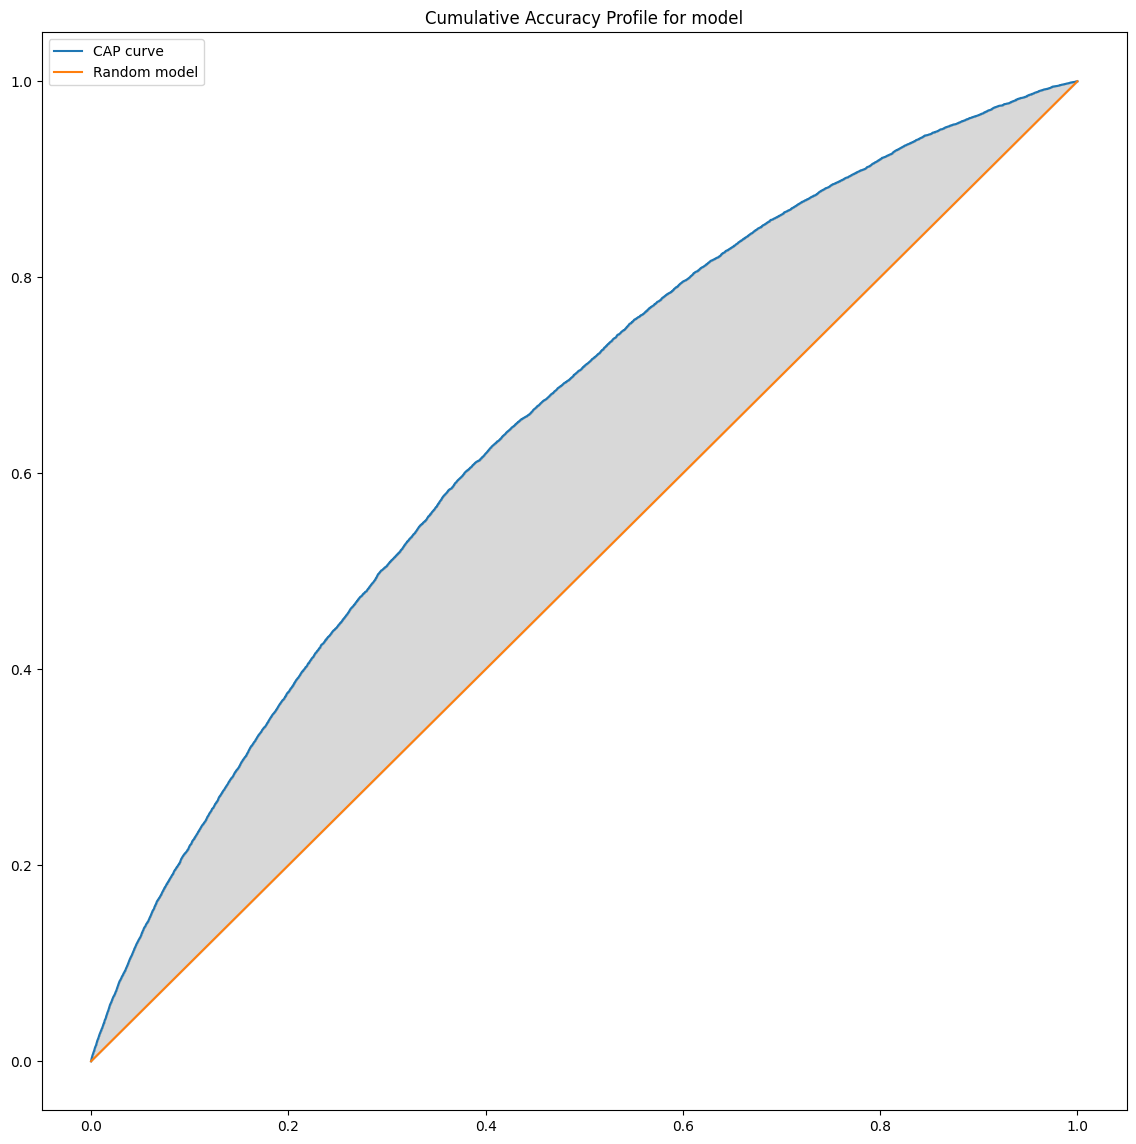

╭─────────────────────────────────────────────── General Gini test ───────────────────────────────────────────────╮
│ ⚠️ Intermediate result with gini 0.30                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

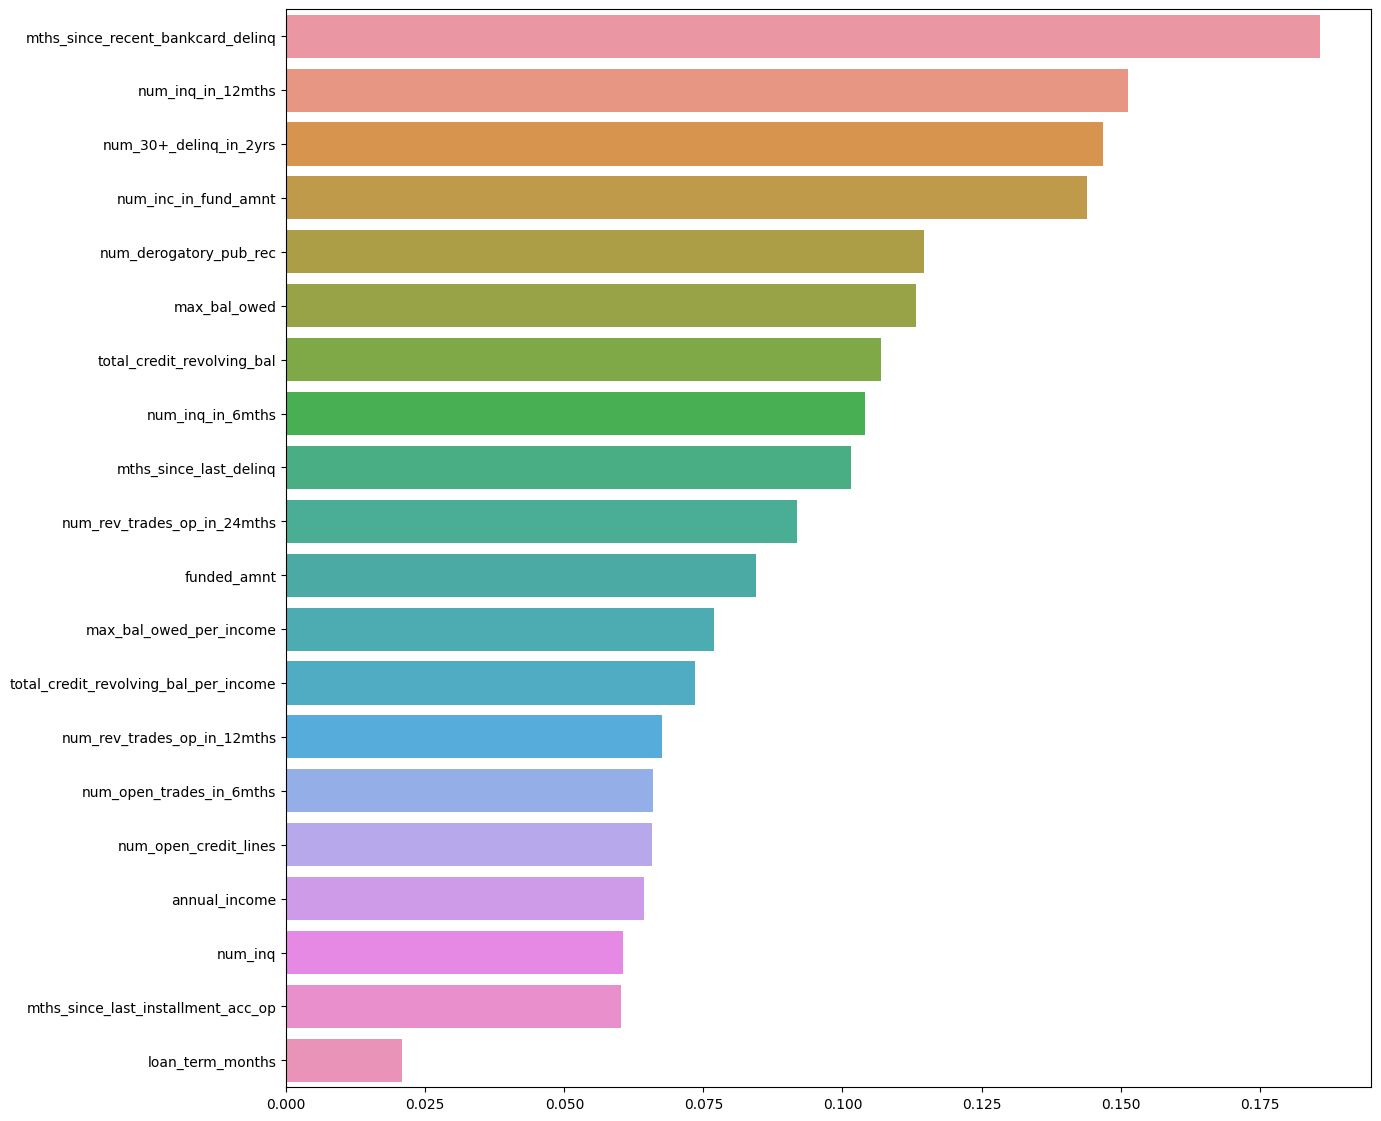

╭─────────────────────────────────────────────── Feature Gini test ───────────────────────────────────────────────╮
│ ⚠️ Intermediate result with red, yellow, green shares 0.05, 0.50, 0.45                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

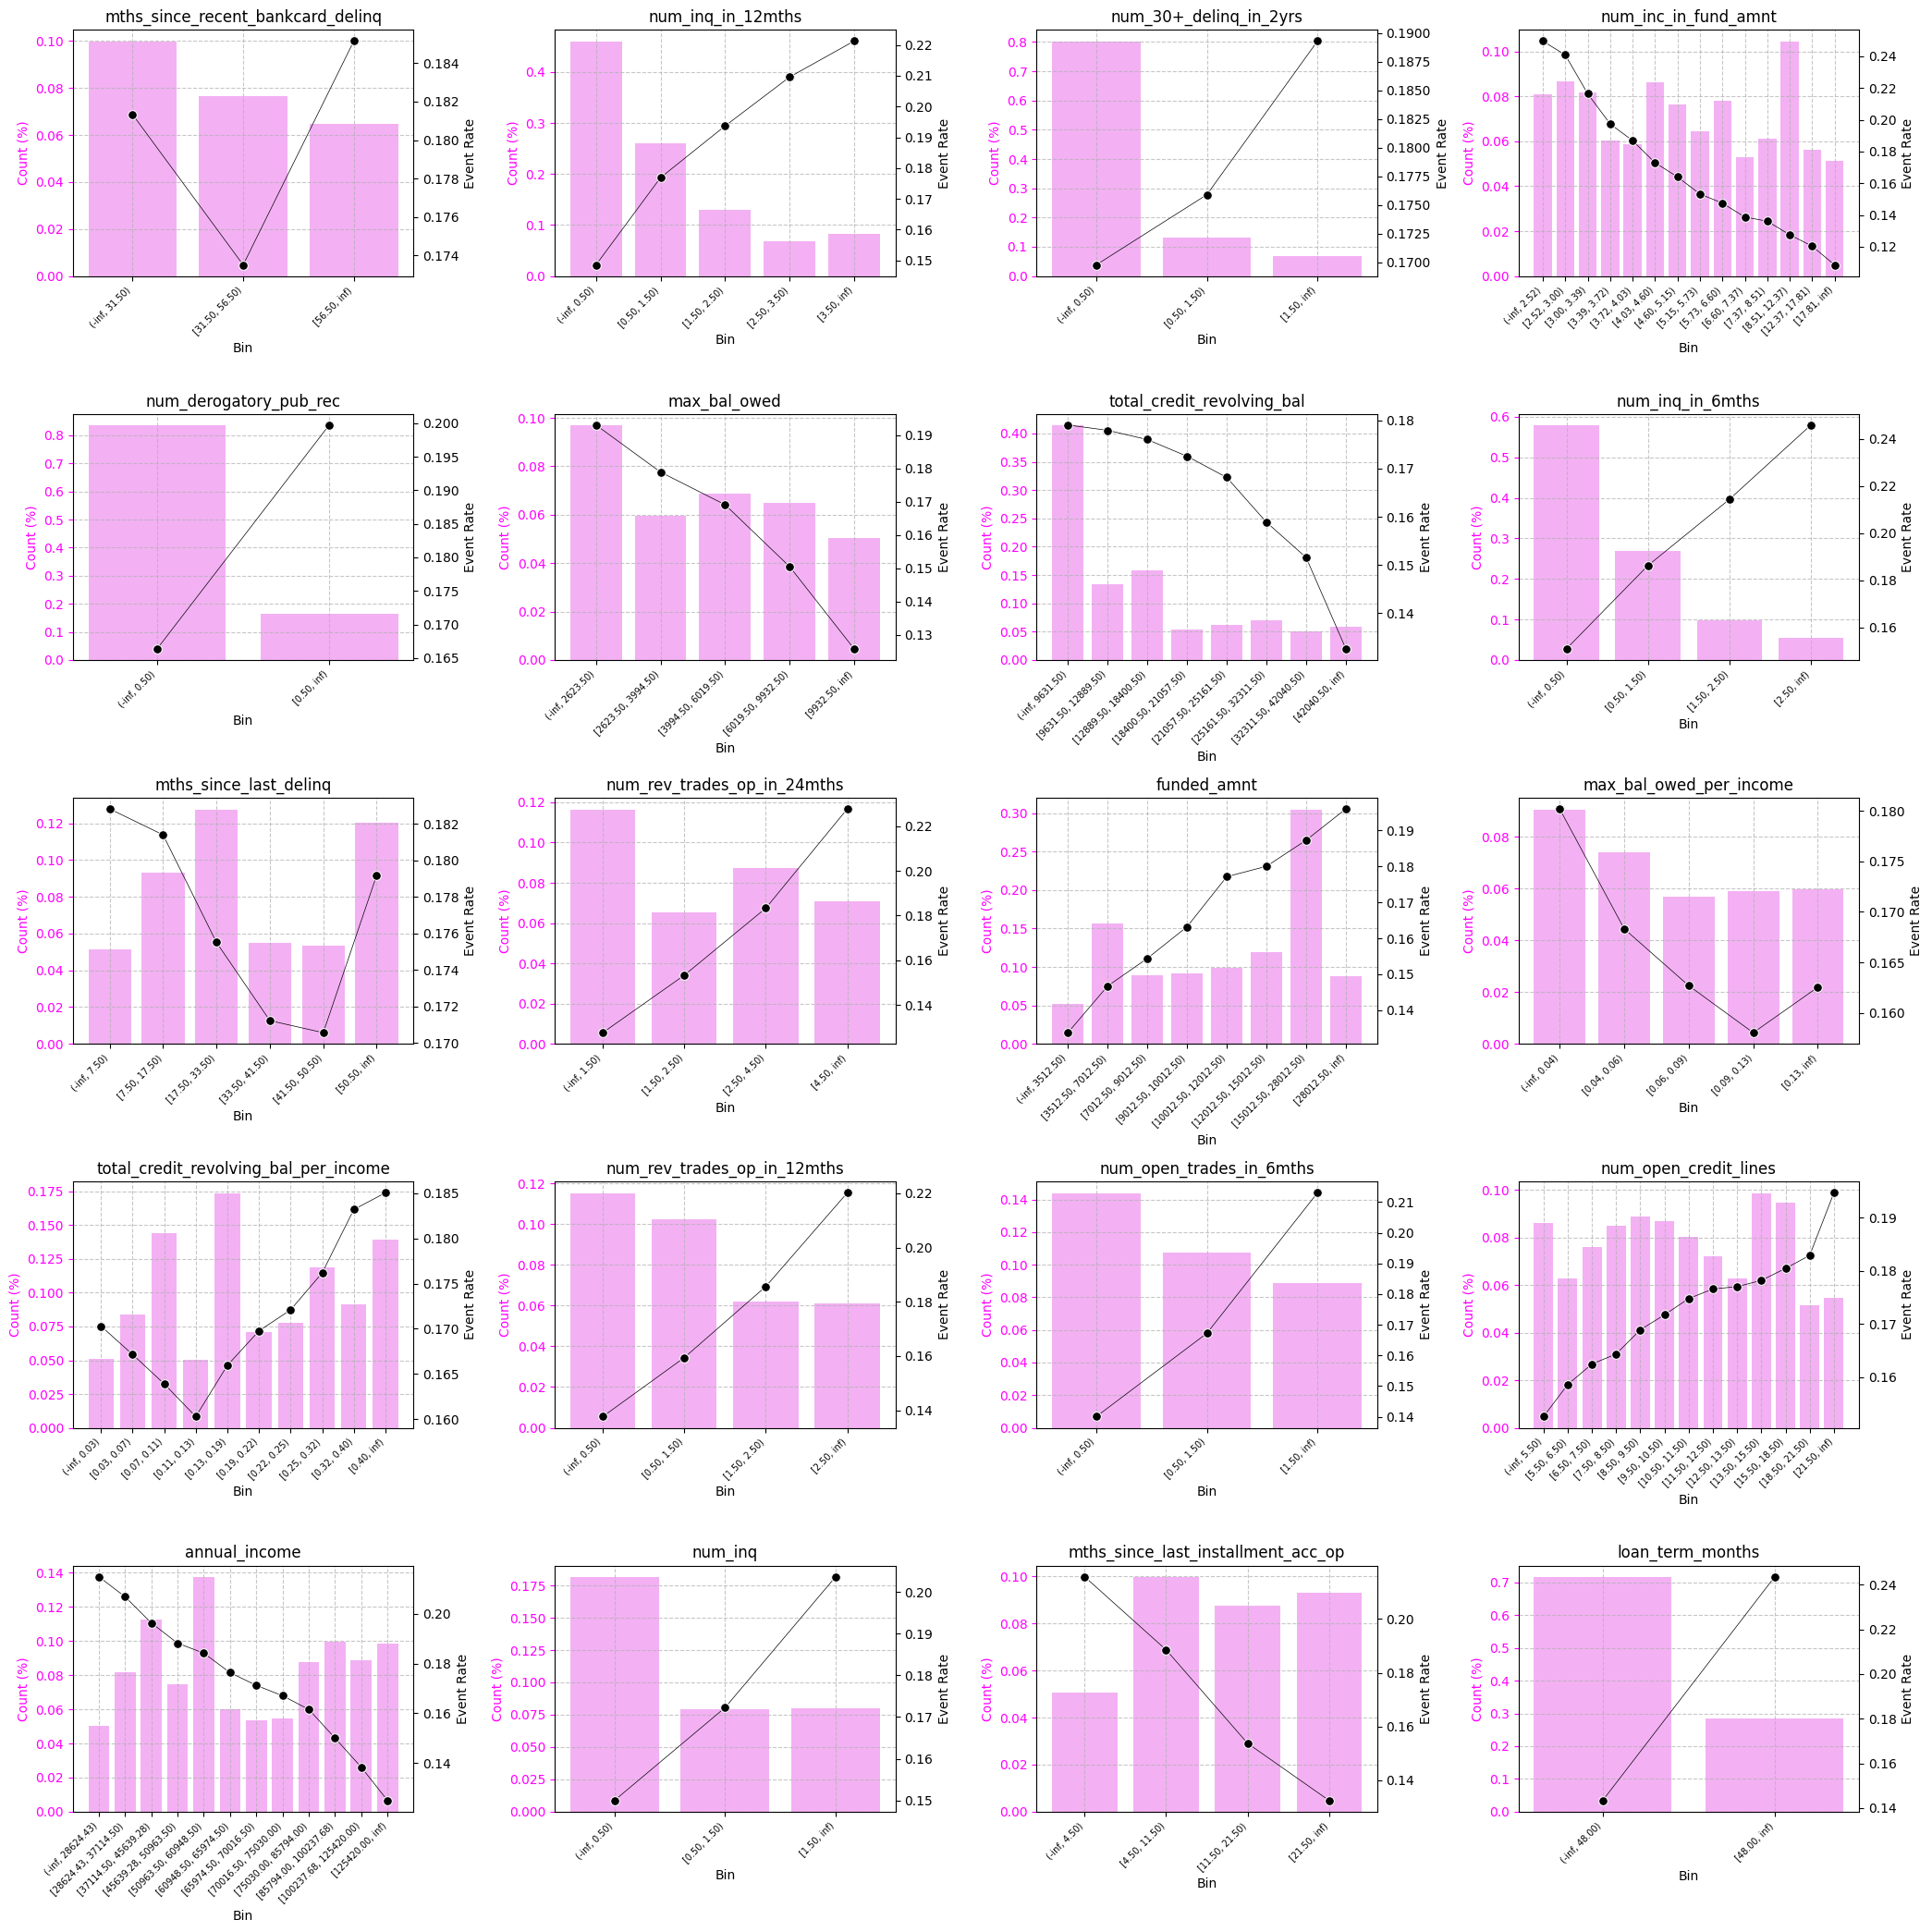

╭───────────────────────────────────────────────── Binning test ──────────────────────────────────────────────────╮
│ ⚠️ Intermediate result with red, yellow, green shares 0.20, 0.55, 0.25                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

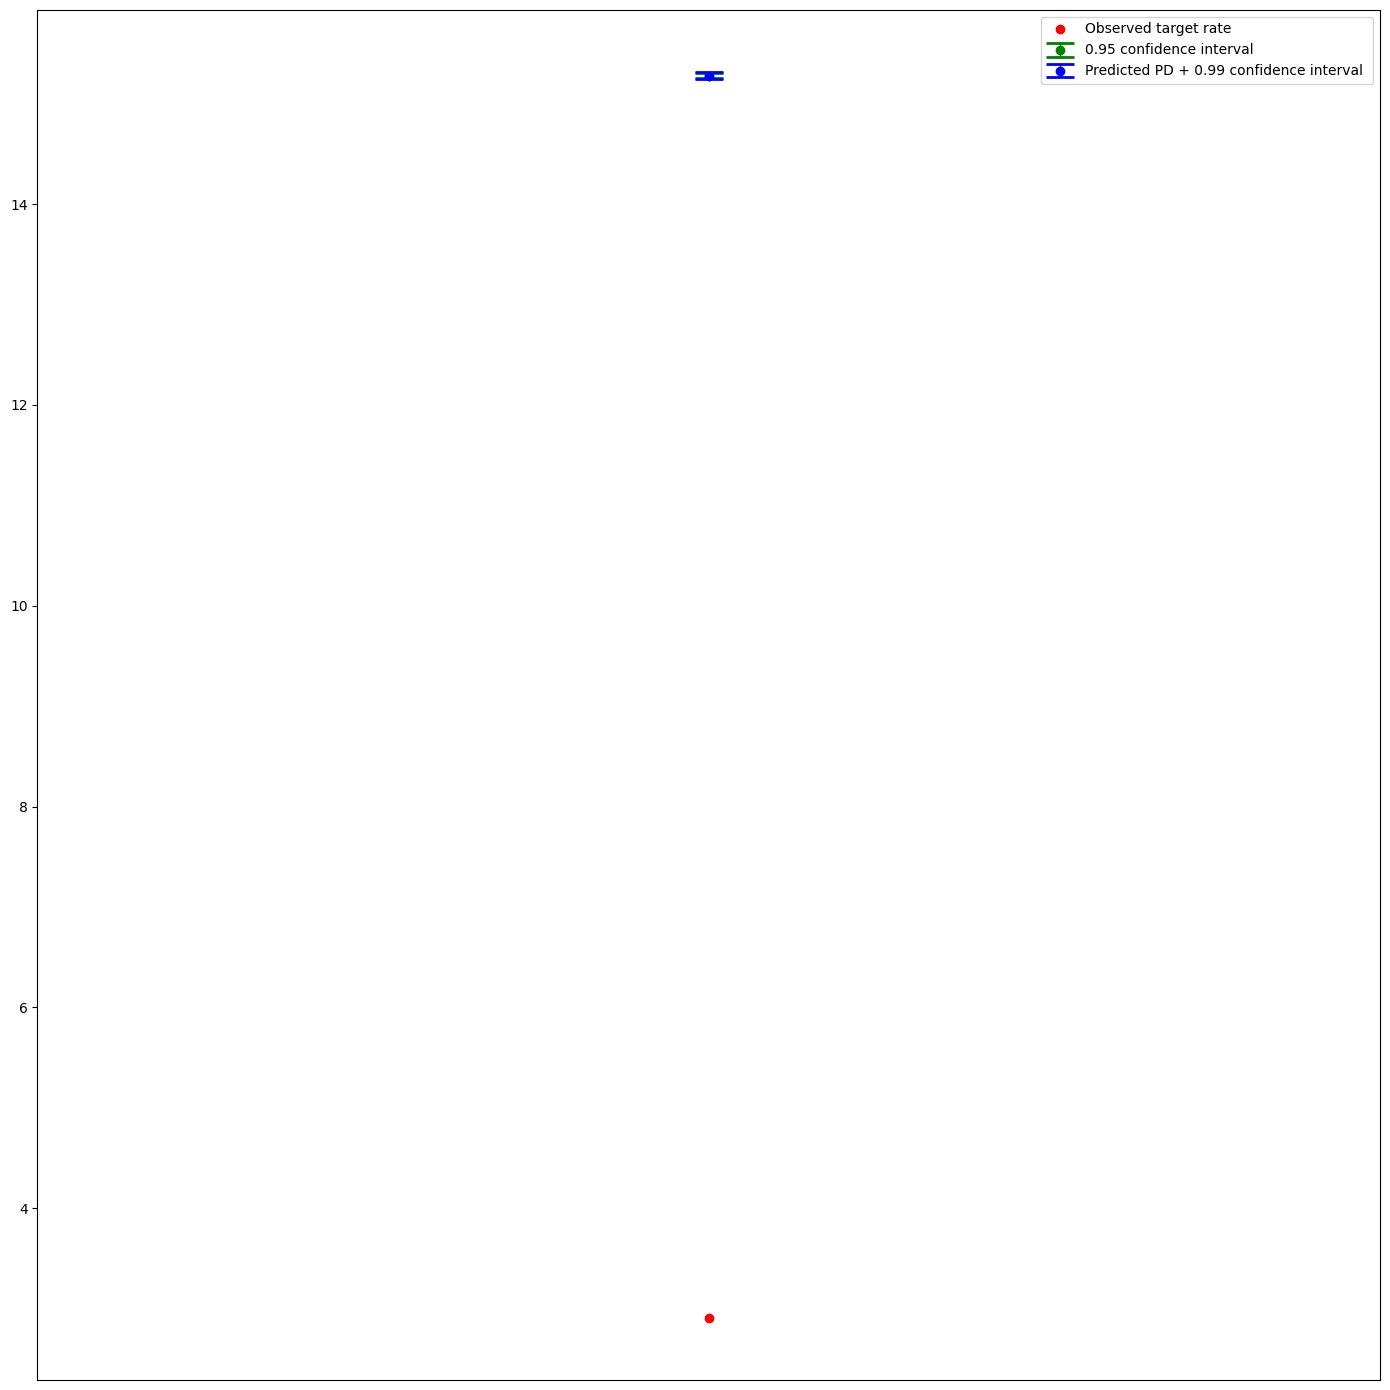

╭─────────────────────────────────────────────── Target Rate test ────────────────────────────────────────────────╮
│ ❌ Test failed with share 425.30%                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

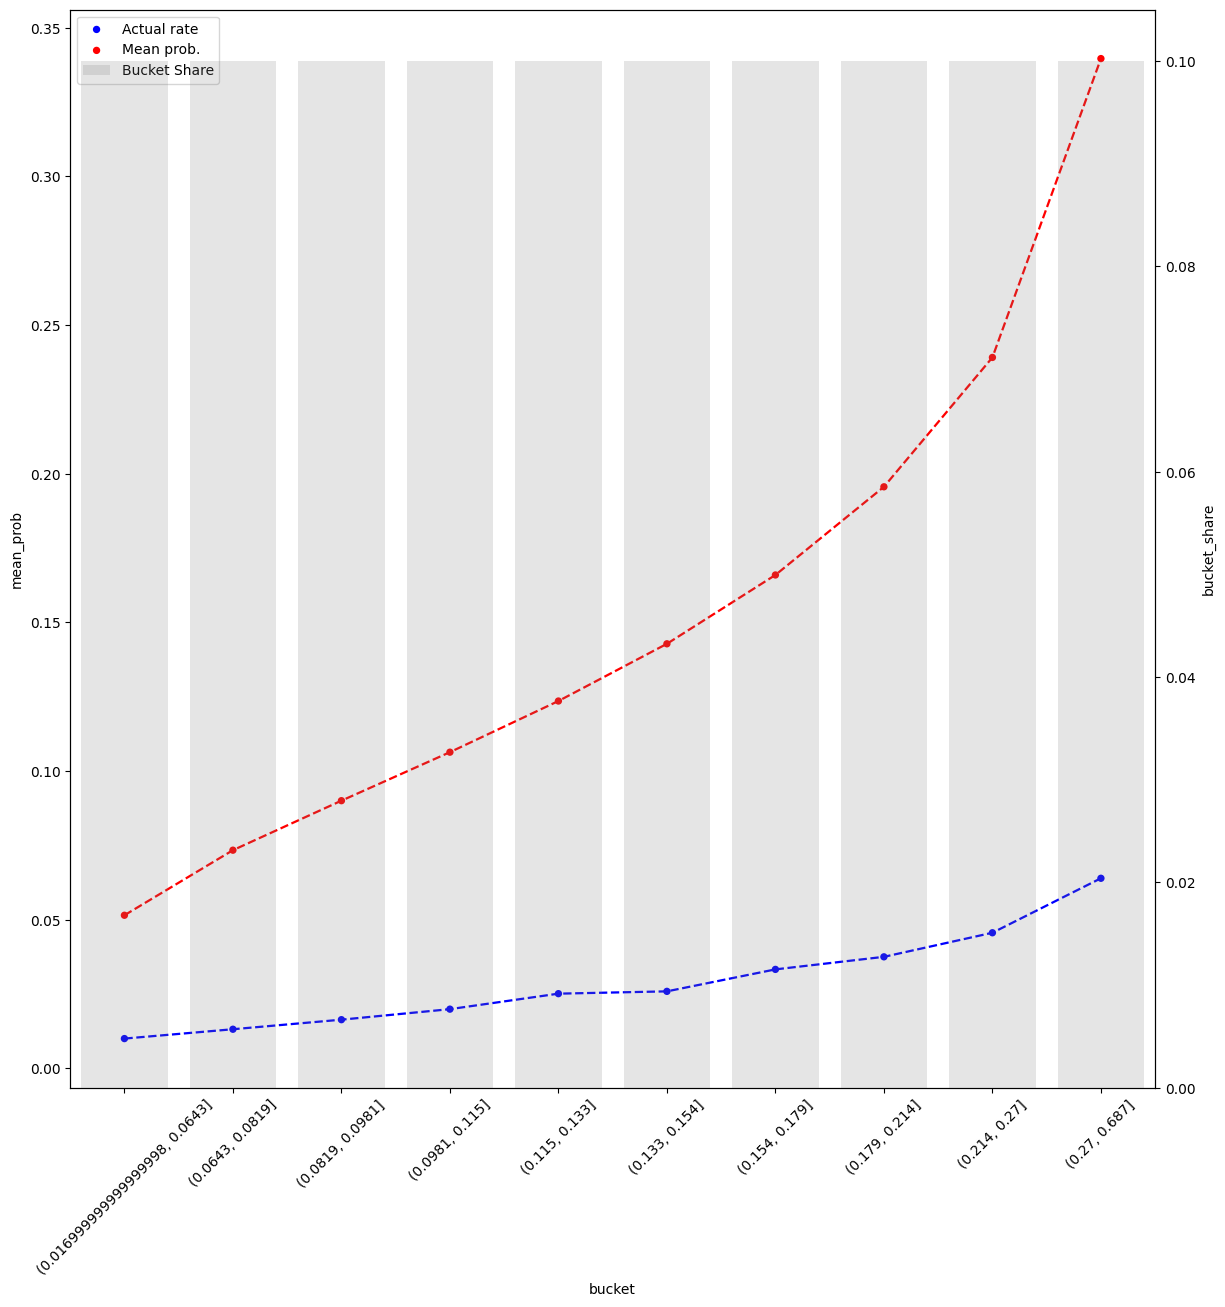

╭──────────────────────────────────────────── Calibration Curve test ─────────────────────────────────────────────╮
│ ❌ Test failed                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

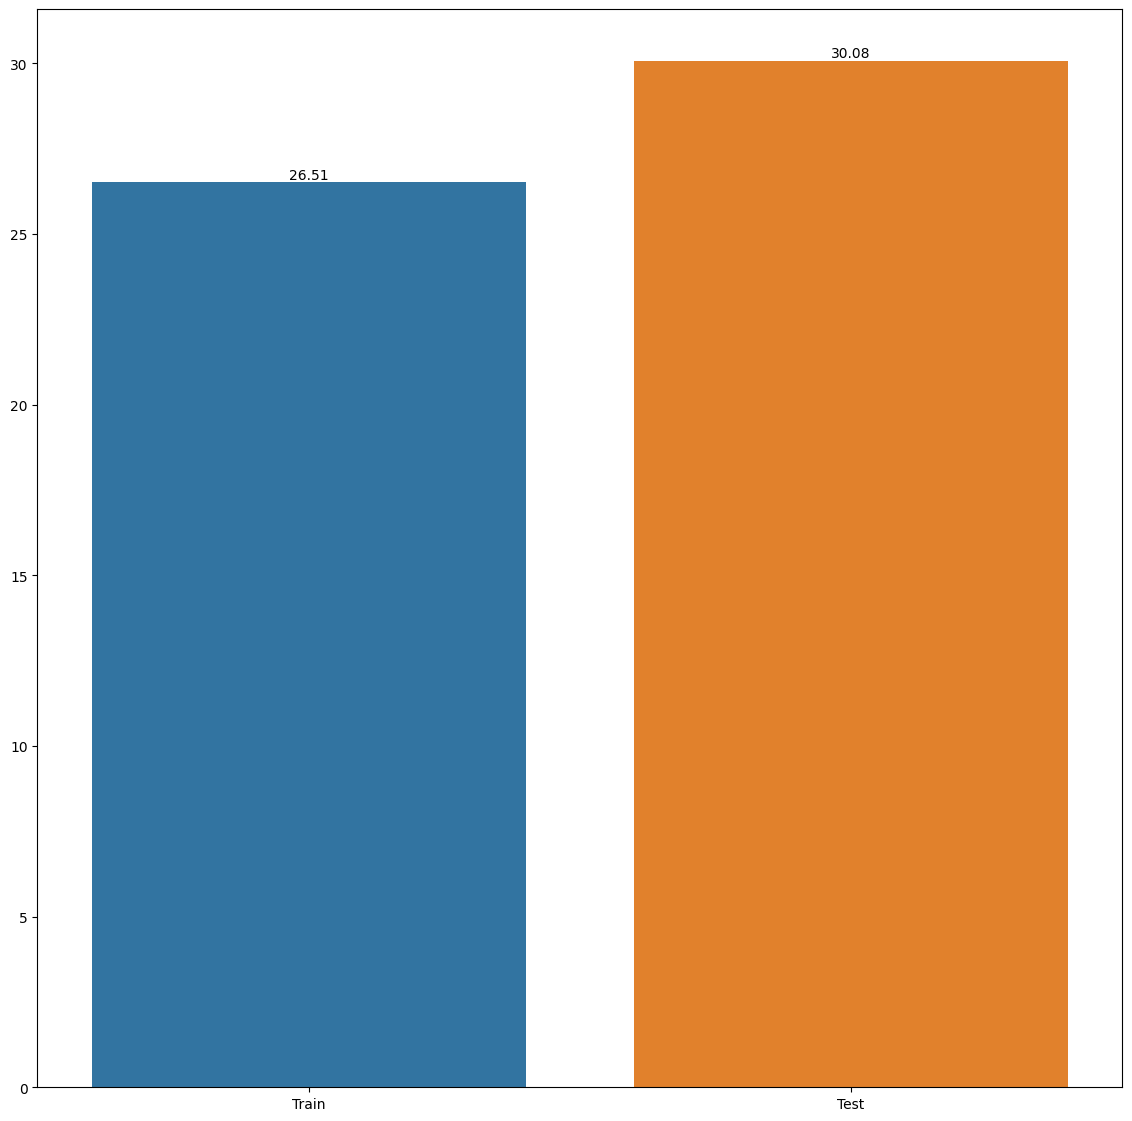

╭─────────────────────────────────────────────── Gini Change test ────────────────────────────────────────────────╮
│ ✅ Test passed with absolute and relative diffs: 3.57 p.p and 13.46%                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

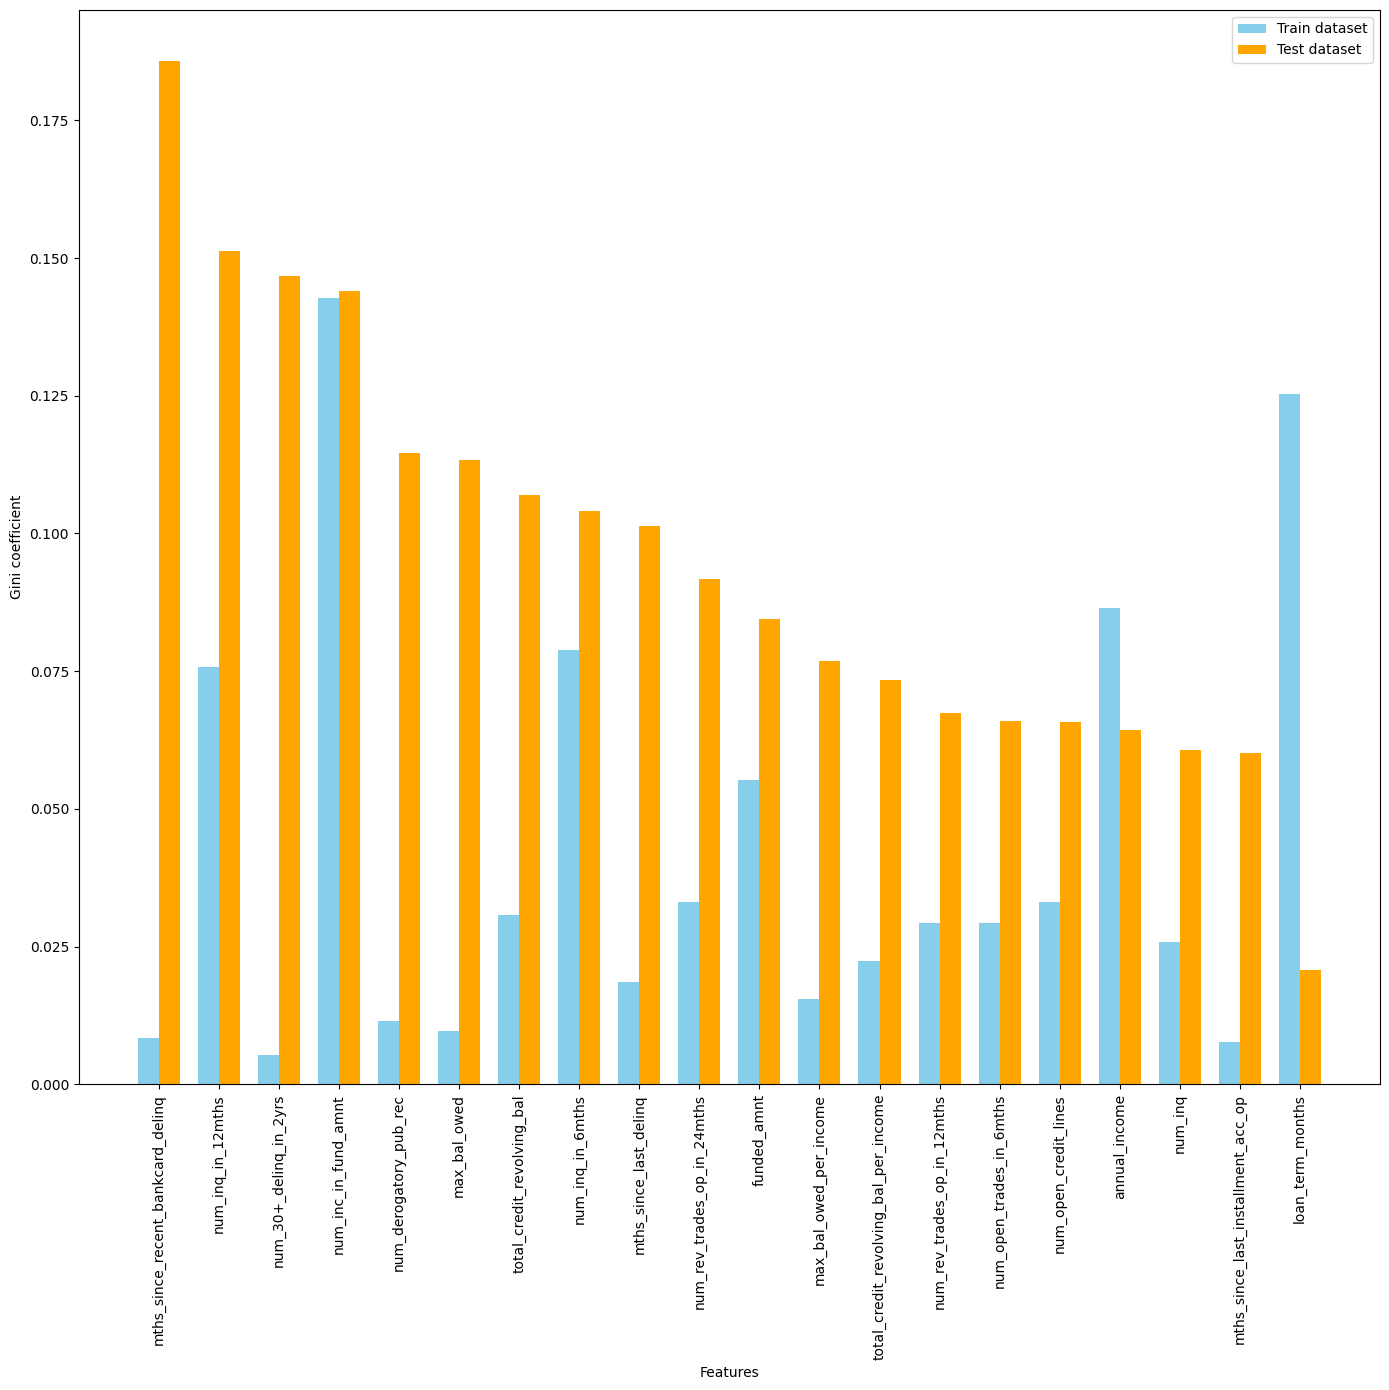

╭─────────────────────────────────────────── Features Gini Change test ───────────────────────────────────────────╮
│ ✅ Test passed with 0.00 , 0.05 , 0.95 shares for red, yellow, green scores                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── Final result ──────────────────────────────────────────────────╮
│ ❌ Validation failed                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [25]:
validator.validate(
    X_val,
    y_val,
    model=pipeline.named_steps.classifier,
    train_data=[X_train, y_train],
    binner=pipeline.named_steps.binner
)

# Data shift 

In one of the past notebooks we have already noticed the presence of label shift, now let's check the presence of covariate shift, for this we use cat boost to train on our out-of-the-box data and look at the AUC, this model will learn to distinguish train from test 

## Preparing data for adversarial method

In [26]:
X_domain_train = X_train.copy()
X_domain_test = X_test.copy()

X_combined = pd.concat([X_domain_train, X_domain_test], axis=0)
y_combined = np.array([0] * len(X_domain_train) + [1] * len(X_domain_test))

In [27]:
cat_features = X_combined.select_dtypes(exclude="number").columns.to_list()
X_combined[cat_features] = X_combined[cat_features].fillna(Config.missing_label)
X_combined, y_combined = shuffle(
    X_combined, 
    y_combined, 
    random_state=Config.seed
)

## Adversarial model

In [28]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    cat_features=cat_features,
    verbose=1,
    random_seed=Config.seed,
)

model.fit(X_combined, y_combined)

y_pred_proba = model.predict_proba(X_combined)[:, 1]
auc = roc_auc_score(y_combined, y_pred_proba)

print(f"Adversarial validation AUC: {auc:.4f}")

0:	learn: 0.4944507	total: 1.02s	remaining: 1m 40s
1:	learn: 0.4020083	total: 1.83s	remaining: 1m 29s
2:	learn: 0.3660047	total: 2.66s	remaining: 1m 26s
3:	learn: 0.3631967	total: 3.41s	remaining: 1m 21s
4:	learn: 0.3598258	total: 4.1s	remaining: 1m 17s
5:	learn: 0.3481878	total: 4.79s	remaining: 1m 14s
6:	learn: 0.3471245	total: 5.5s	remaining: 1m 13s
7:	learn: 0.3466567	total: 6.1s	remaining: 1m 10s
8:	learn: 0.3417369	total: 6.82s	remaining: 1m 8s
9:	learn: 0.3394515	total: 7.51s	remaining: 1m 7s
10:	learn: 0.3383852	total: 8.17s	remaining: 1m 6s
11:	learn: 0.3381285	total: 8.79s	remaining: 1m 4s
12:	learn: 0.3375733	total: 9.7s	remaining: 1m 4s
13:	learn: 0.3373848	total: 10.5s	remaining: 1m 4s
14:	learn: 0.3372369	total: 11.3s	remaining: 1m 4s
15:	learn: 0.3370713	total: 12s	remaining: 1m 3s
16:	learn: 0.3369306	total: 12.7s	remaining: 1m 2s
17:	learn: 0.3368004	total: 13.3s	remaining: 1m
18:	learn: 0.3363774	total: 14s	remaining: 59.6s
19:	learn: 0.3361676	total: 14.7s	remaining:

## Most important features for data shift detection

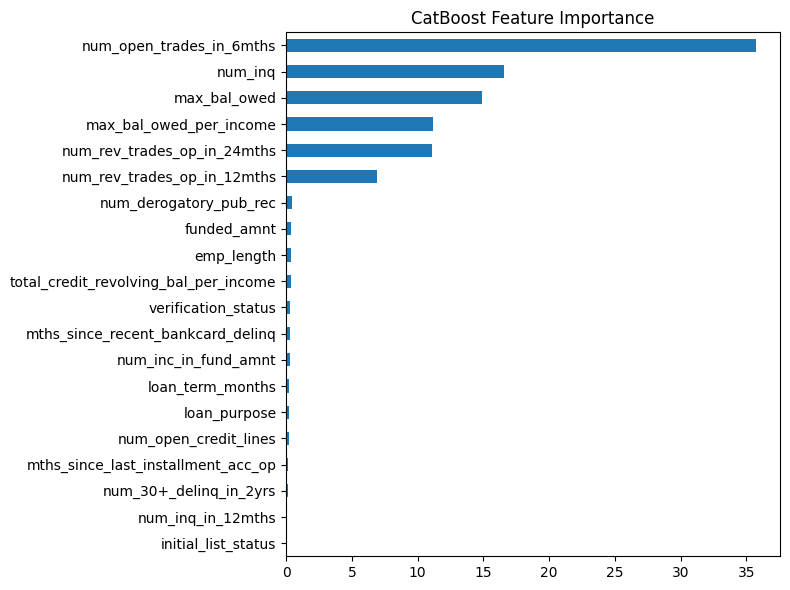

In [29]:
importances = model.get_feature_importance(type='PredictionValuesChange')
features = model.feature_names_

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

feat_imp.head(20).plot(kind='barh', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()


As we see on the test sample there is label and covariate shift and we need to adapt the model to this

# Dealing with data shift 

Let's try a two-step approach, we use CatBoost predictions to combat the covariance shift, and use Bayesian correction for the predicted probabilities to combat the label shift 

## Bayes correction

In [30]:
eps = 1e-9

def bayes_correction(p_model: np.ndarray, pi_train: float, pi_test: float) -> np.ndarray:
    p_model = p_model[:, 1]

    num = (pi_test / (pi_train + eps)) * p_model
    den = num + ((1 - pi_test) / (1 - pi_train + eps)) * (1 - p_model)

    return num / (den + eps)


To avoid data leakage, we take a small subsample and sample val to find the mean (in real conditions we would get this data at the beginning of the period)

In [31]:
pi_train = y_train.mean()

rng = np.random.default_rng(seed=Config.seed)

pi_val = rng.choice(y_val, size=20000, replace=False).mean()

print(f"Pi_train: {pi_train:.4f}")
print(f"Pi_val: {pi_val:.4f}")

Pi_train: 0.1719
Pi_val: 0.0299


## New model

In [32]:
class SGDClassifierWrapper(SGDClassifier):
    def predict_proba(self, *args, **kwargs):
        p = super().predict_proba(*args, **kwargs)
        return bayes_correction(
            p,
            pi_train=pi_train,
            pi_test=pi_val
        )

In [33]:
pipeline = Pipeline([
    ('binner', Binner(PARAMS)),  
    ('classifier', SGDClassifierWrapper(
        loss='log_loss', 
        penalty='l2',     
        max_iter=1000,
        tol=1e-3,
        random_state=Config.seed,
        learning_rate='optimal',
        verbose=1
    ))
])



class ShiftAwarePipeline(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.pipeline = pipeline
        self.domain_model = model
    
    def fit(self, X_train: pd.DataFrame, y_train: np.ndarray):
        X_train_dom = X_train.copy()
        X_train_dom[cat_features] = X_train_dom[cat_features].fillna(Config.missing_label)
        
        p_test_x = self.domain_model.predict_proba(X_train_dom)[:, 1]
        weights = p_test_x / (1 - p_test_x + 1e-6)

        self.pipeline.fit(X_train, y_train, classifier__sample_weight=weights)

        return self

    def predict_proba(self, X: pd.DataFrame):
        return self.pipeline.predict_proba(X) 

In [34]:
final_model = ShiftAwarePipeline()
final_model.fit(X_train, y_train);

-- Epoch 1
Norm: 2.64, NNZs: 26, Bias: -1.561262, T: 1312368, Avg. loss: 0.440880
Total training time: 0.49 seconds.
-- Epoch 2
Norm: 2.66, NNZs: 26, Bias: -1.472426, T: 2624736, Avg. loss: 0.437667
Total training time: 1.03 seconds.
-- Epoch 3
Norm: 2.59, NNZs: 26, Bias: -1.537367, T: 3937104, Avg. loss: 0.437571
Total training time: 1.58 seconds.
-- Epoch 4
Norm: 2.64, NNZs: 26, Bias: -1.464615, T: 5249472, Avg. loss: 0.437459
Total training time: 2.12 seconds.
-- Epoch 5
Norm: 2.59, NNZs: 26, Bias: -1.530820, T: 6561840, Avg. loss: 0.437478
Total training time: 2.65 seconds.
-- Epoch 6
Norm: 2.62, NNZs: 26, Bias: -1.458313, T: 7874208, Avg. loss: 0.437444
Total training time: 3.18 seconds.
-- Epoch 7
Norm: 2.64, NNZs: 26, Bias: -1.508806, T: 9186576, Avg. loss: 0.437482
Total training time: 3.72 seconds.
Convergence after 7 epochs took 3.72 seconds


## Val classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.662
Brier Score 0.028
Divergence Score 0.286

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



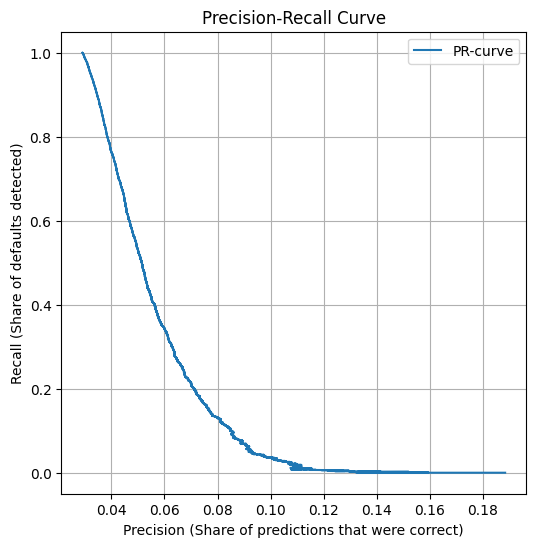


--------------------------------------------------
F1 Curve
--------------------------------------------------



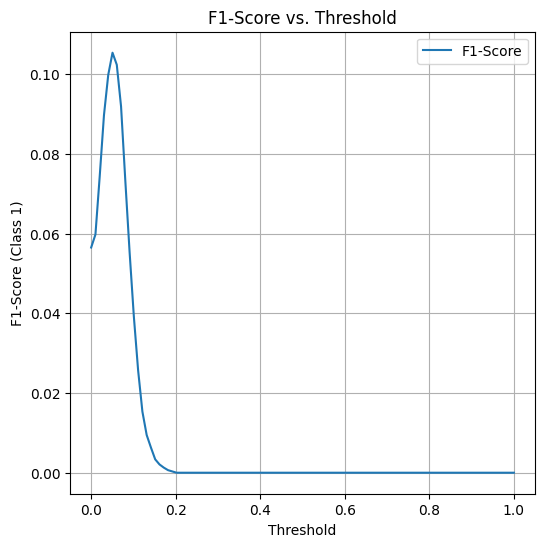


--------------------------------------------------
Calibration Curve
--------------------------------------------------



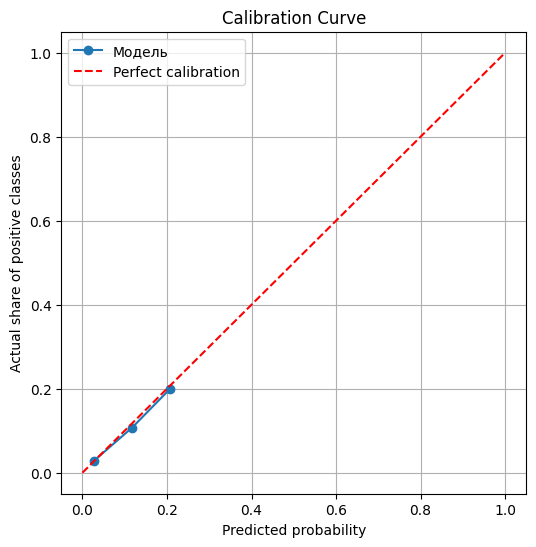

In [35]:
classification_report(y_val, final_model.predict_proba(X_val), figsize=(6, 6))

## Test classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.660
Brier Score 0.097
Divergence Score 0.276

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



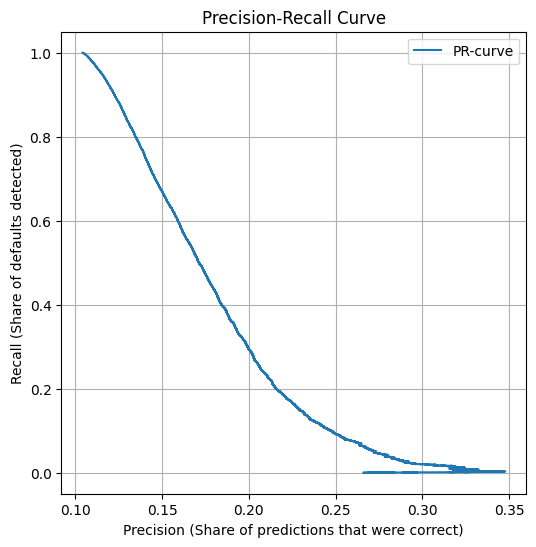


--------------------------------------------------
F1 Curve
--------------------------------------------------



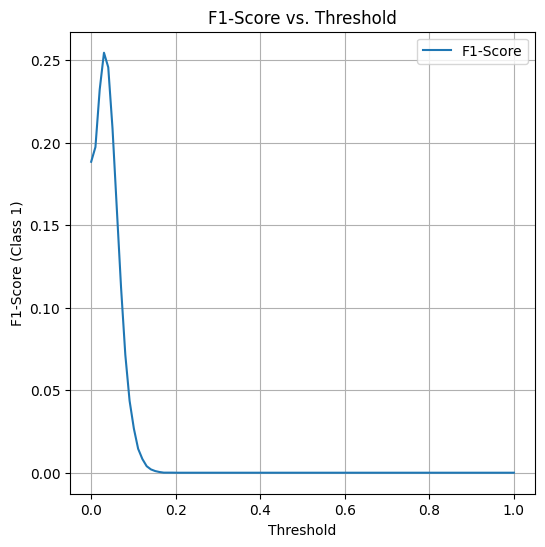


--------------------------------------------------
Calibration Curve
--------------------------------------------------



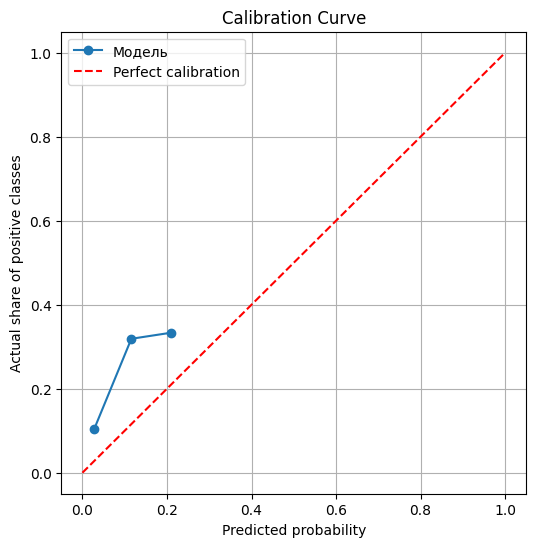

In [36]:
classification_report(y_test, final_model.predict_proba(X_test), figsize=(6, 6))

## Validation 

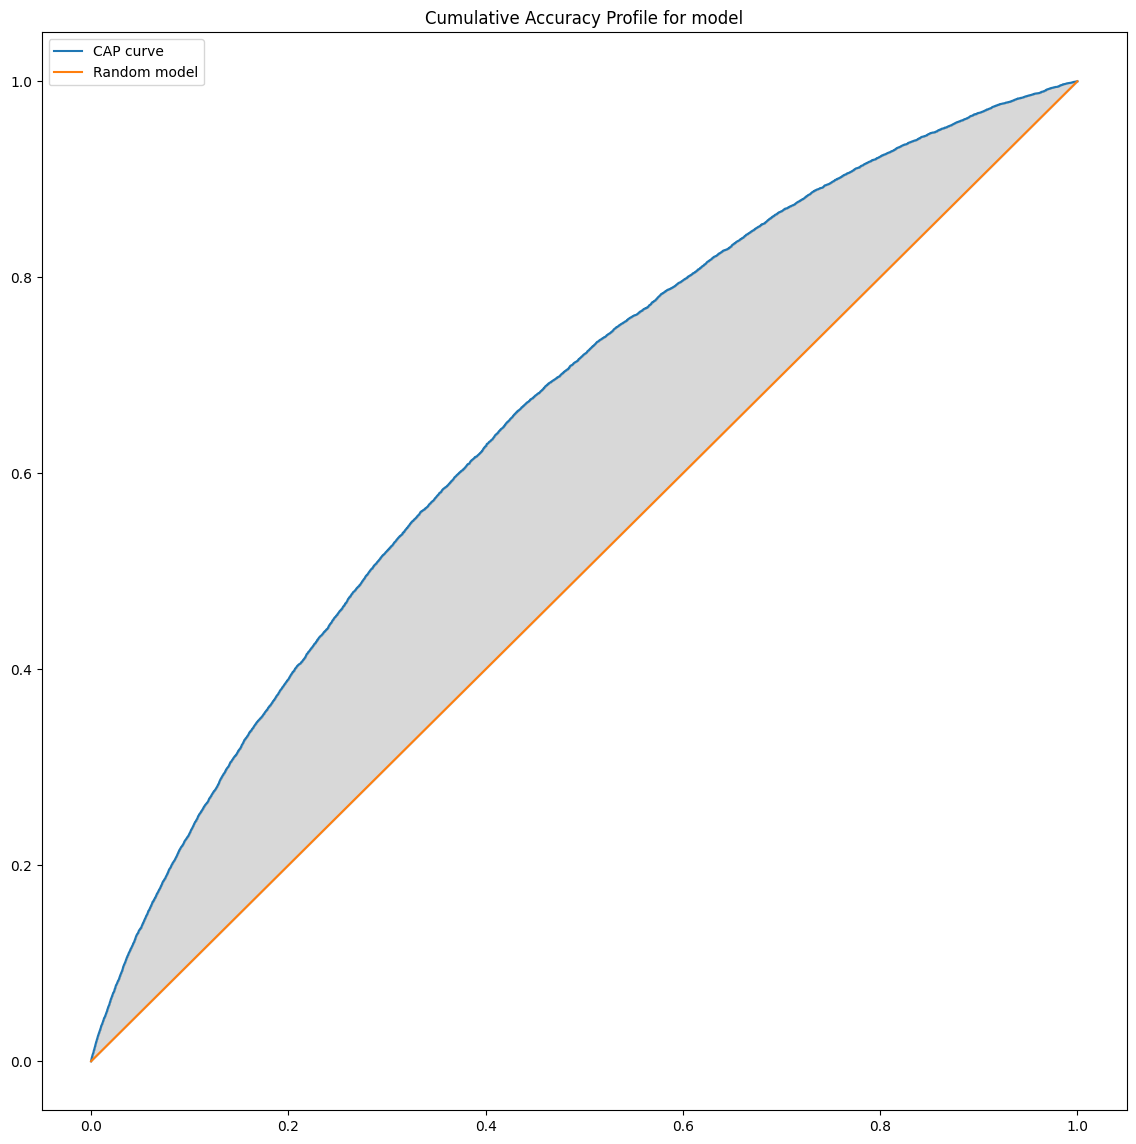

╭─────────────────────────────────────────────── General Gini test ───────────────────────────────────────────────╮
│ ⚠️ Intermediate result with gini 0.32                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

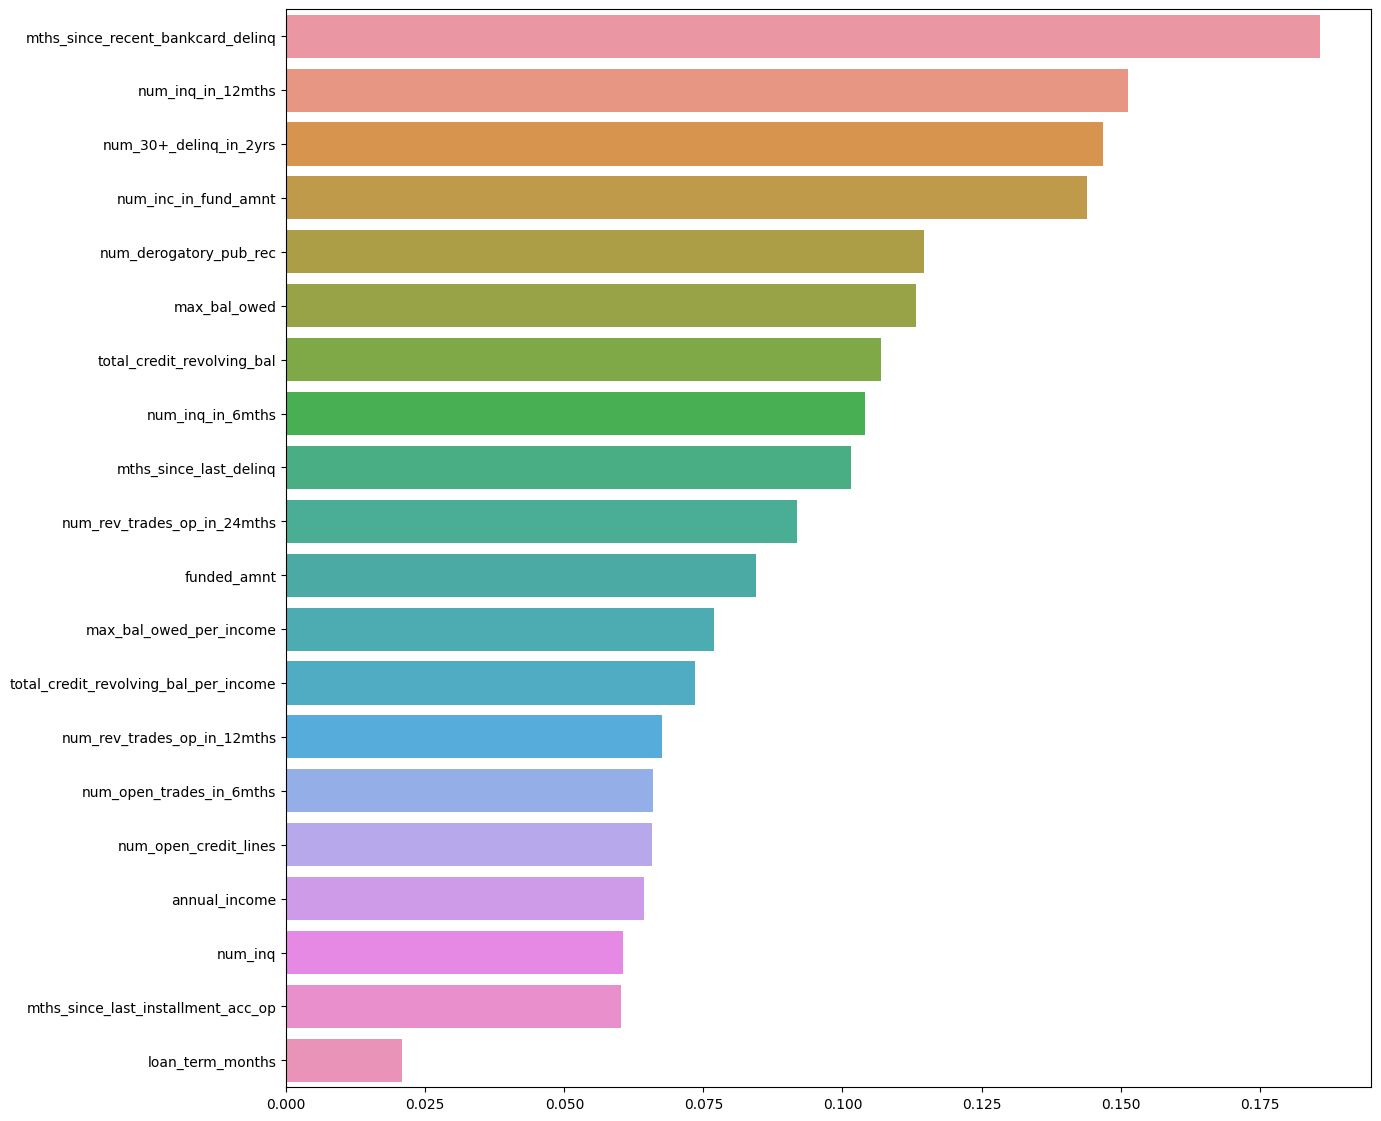

╭─────────────────────────────────────────────── Feature Gini test ───────────────────────────────────────────────╮
│ ⚠️ Intermediate result with red, yellow, green shares 0.05, 0.50, 0.45                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

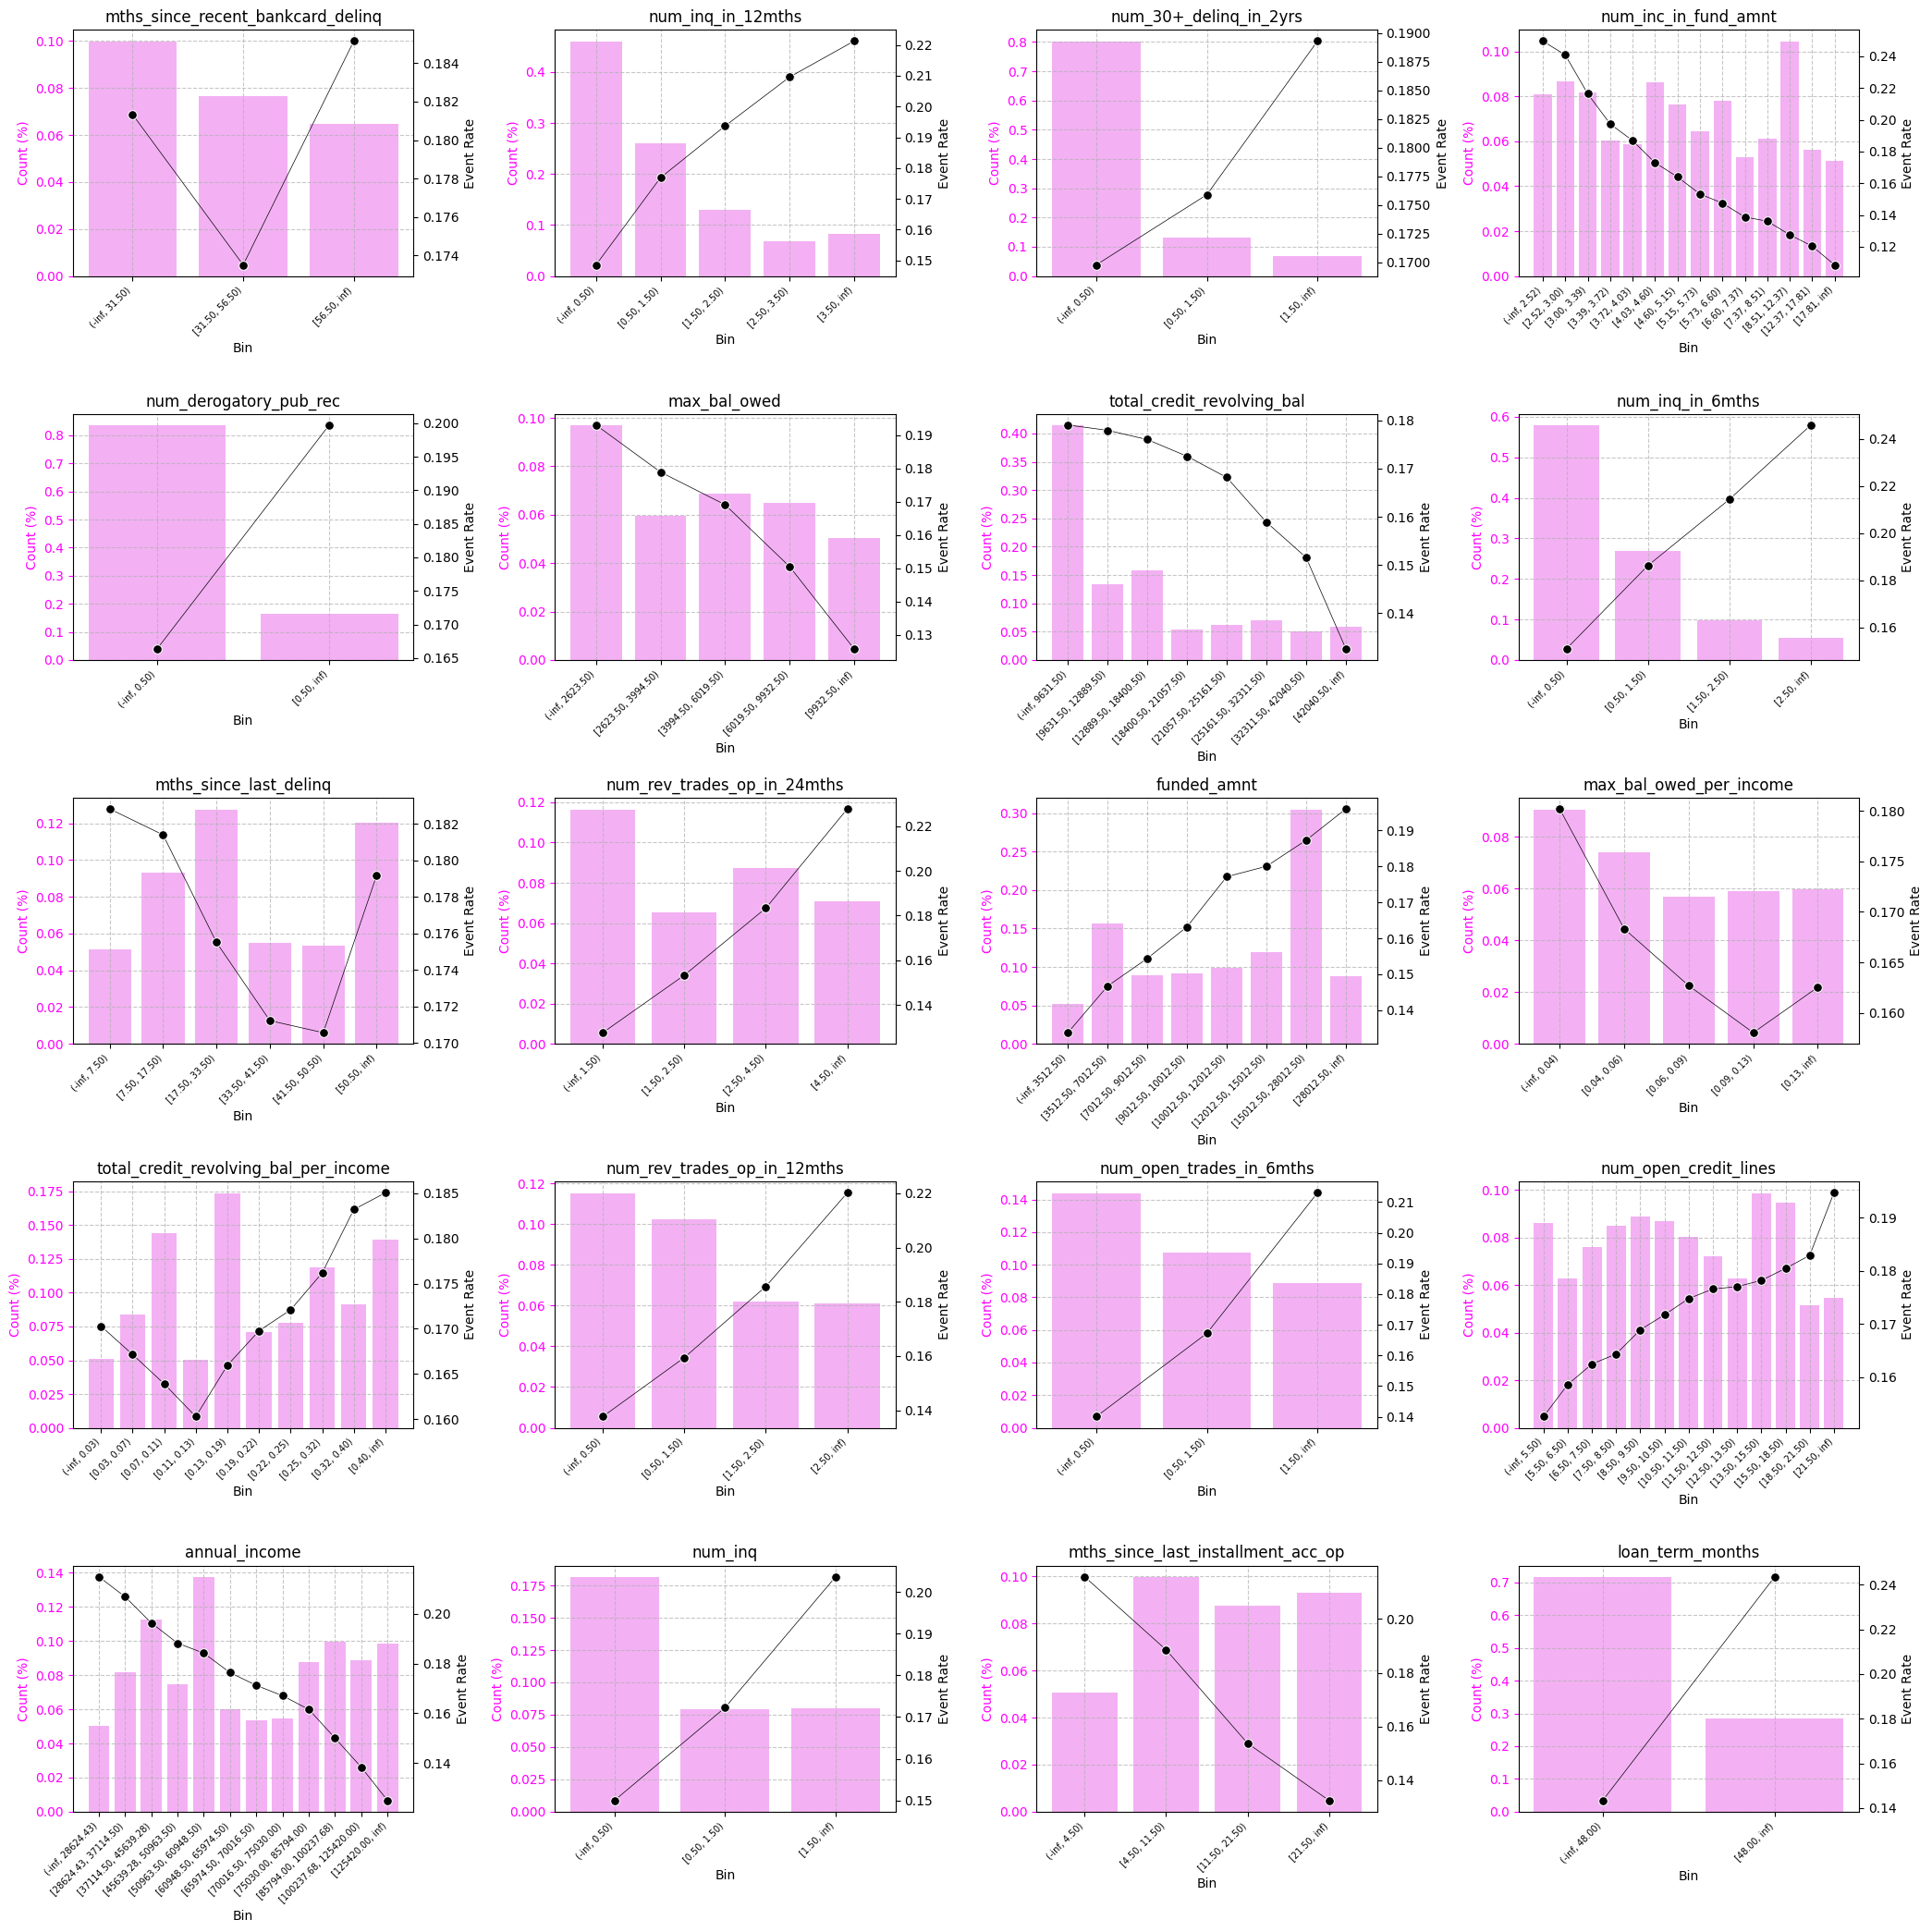

╭───────────────────────────────────────────────── Binning test ──────────────────────────────────────────────────╮
│ ⚠️ Intermediate result with red, yellow, green shares 0.20, 0.55, 0.25                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

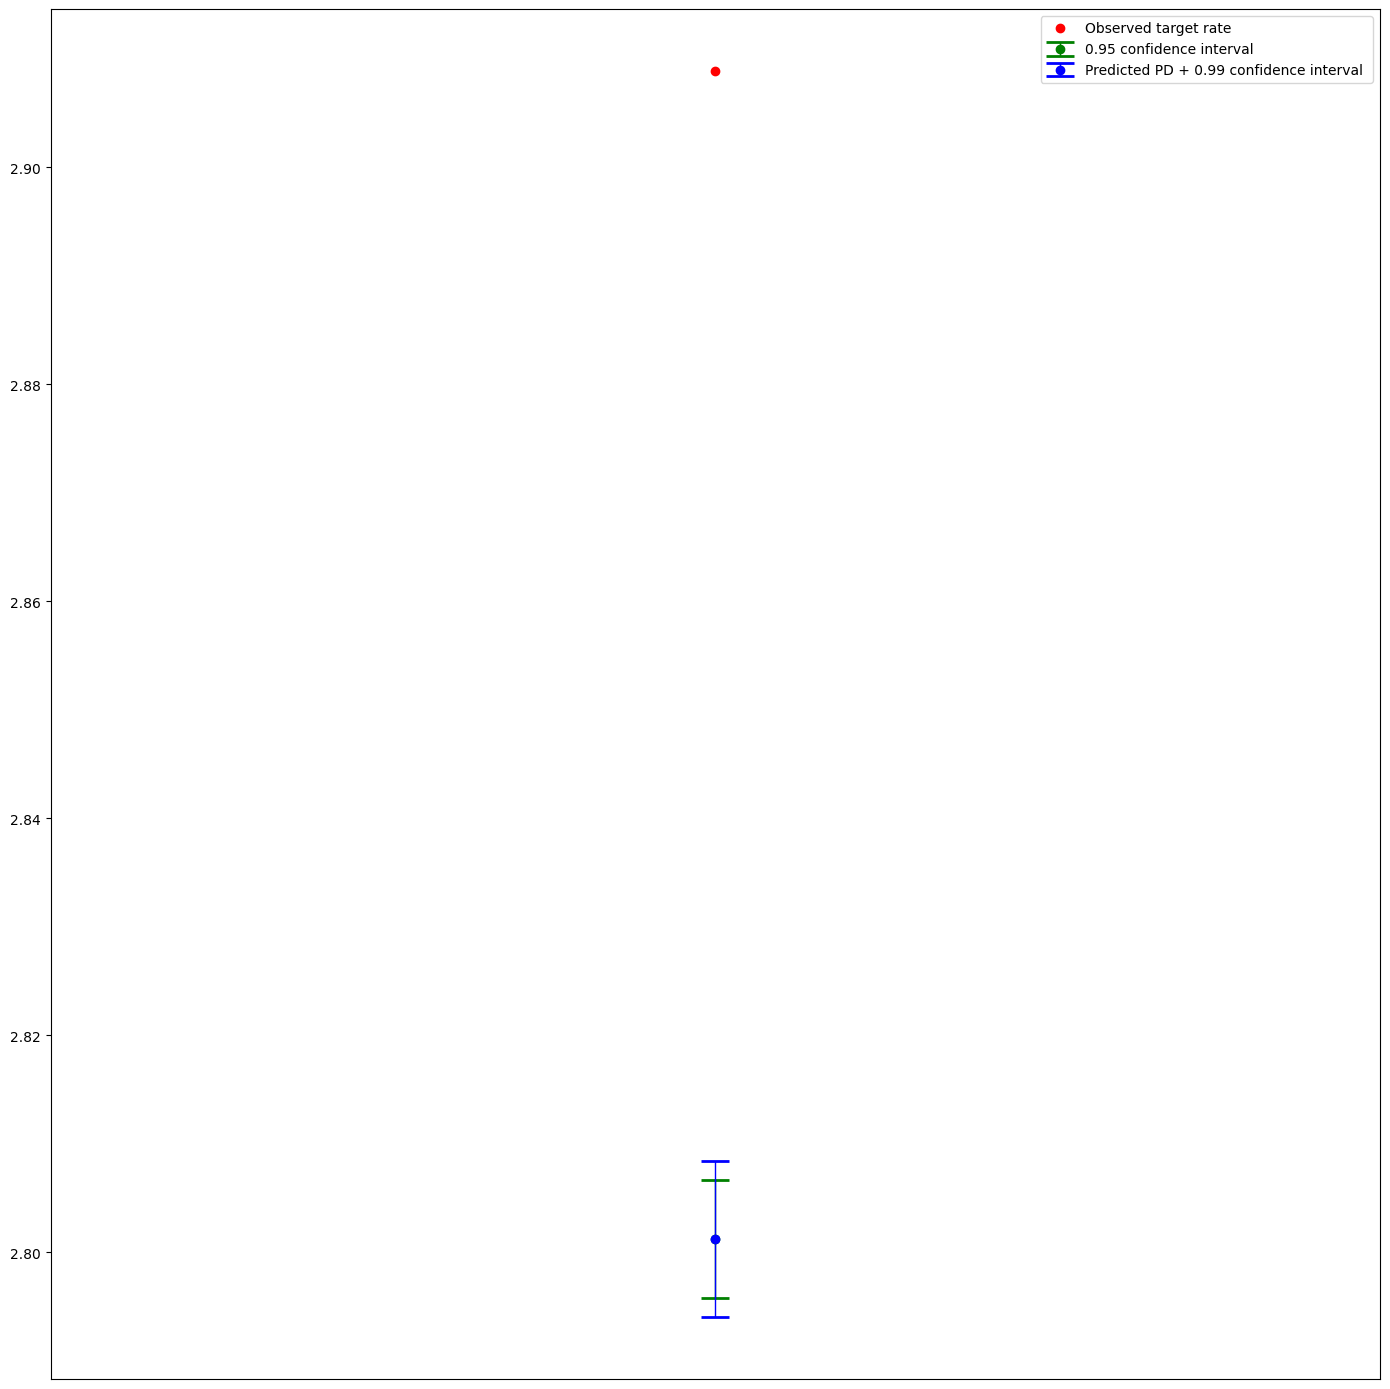

╭─────────────────────────────────────────────── Target Rate test ────────────────────────────────────────────────╮
│ ✅ Test passed with share 3.70%                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

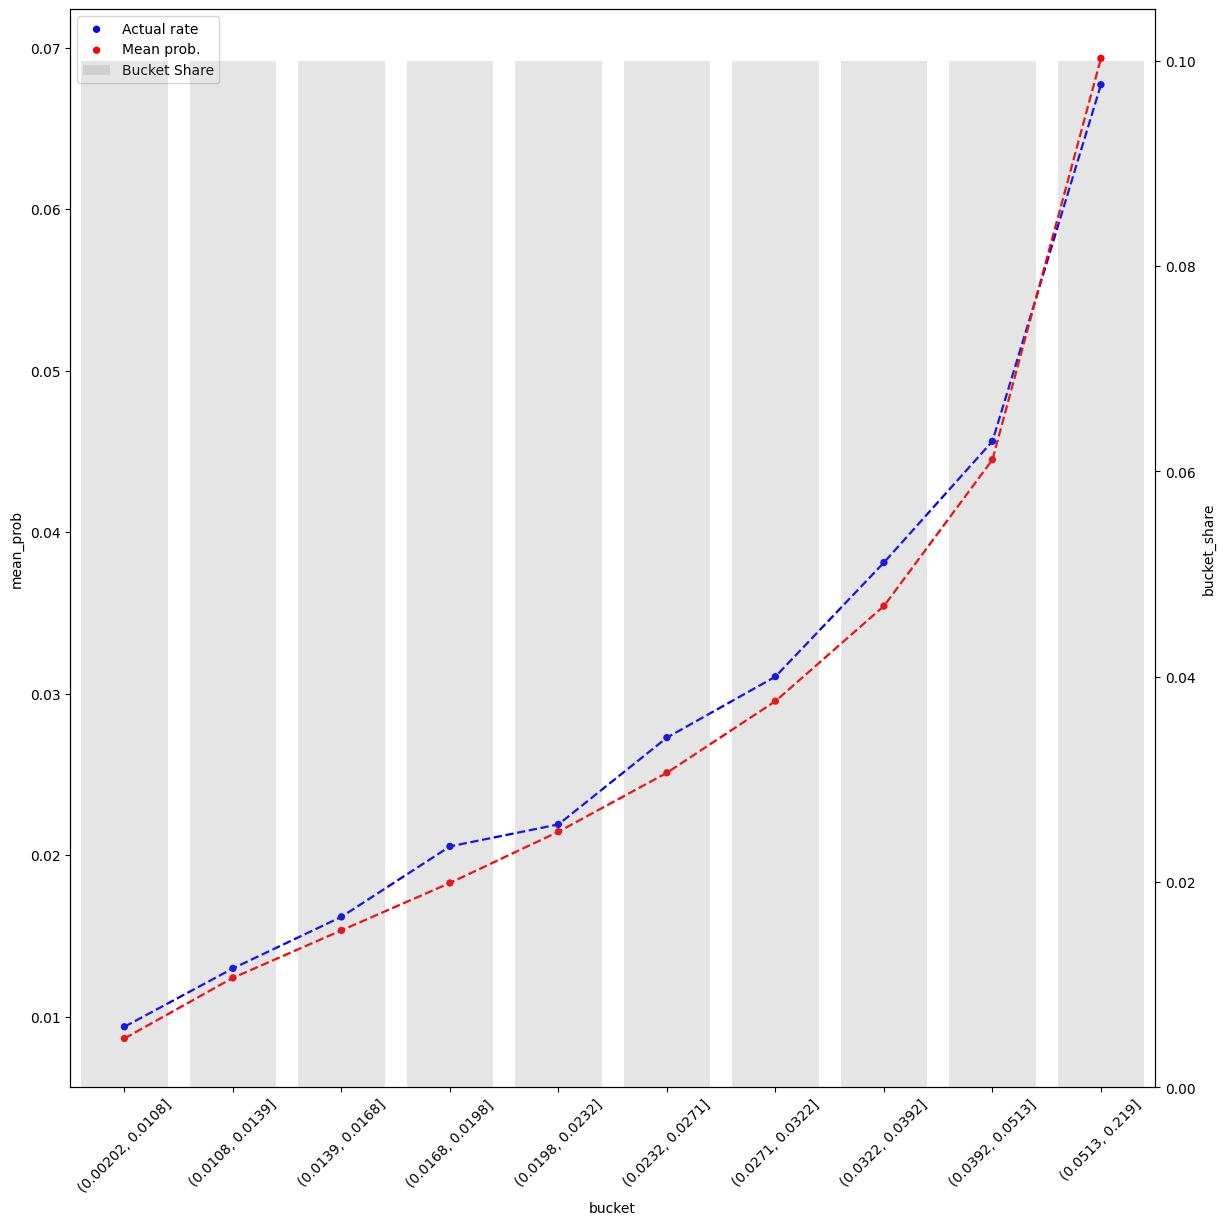

╭──────────────────────────────────────────── Calibration Curve test ─────────────────────────────────────────────╮
│ ✅ Test passed                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

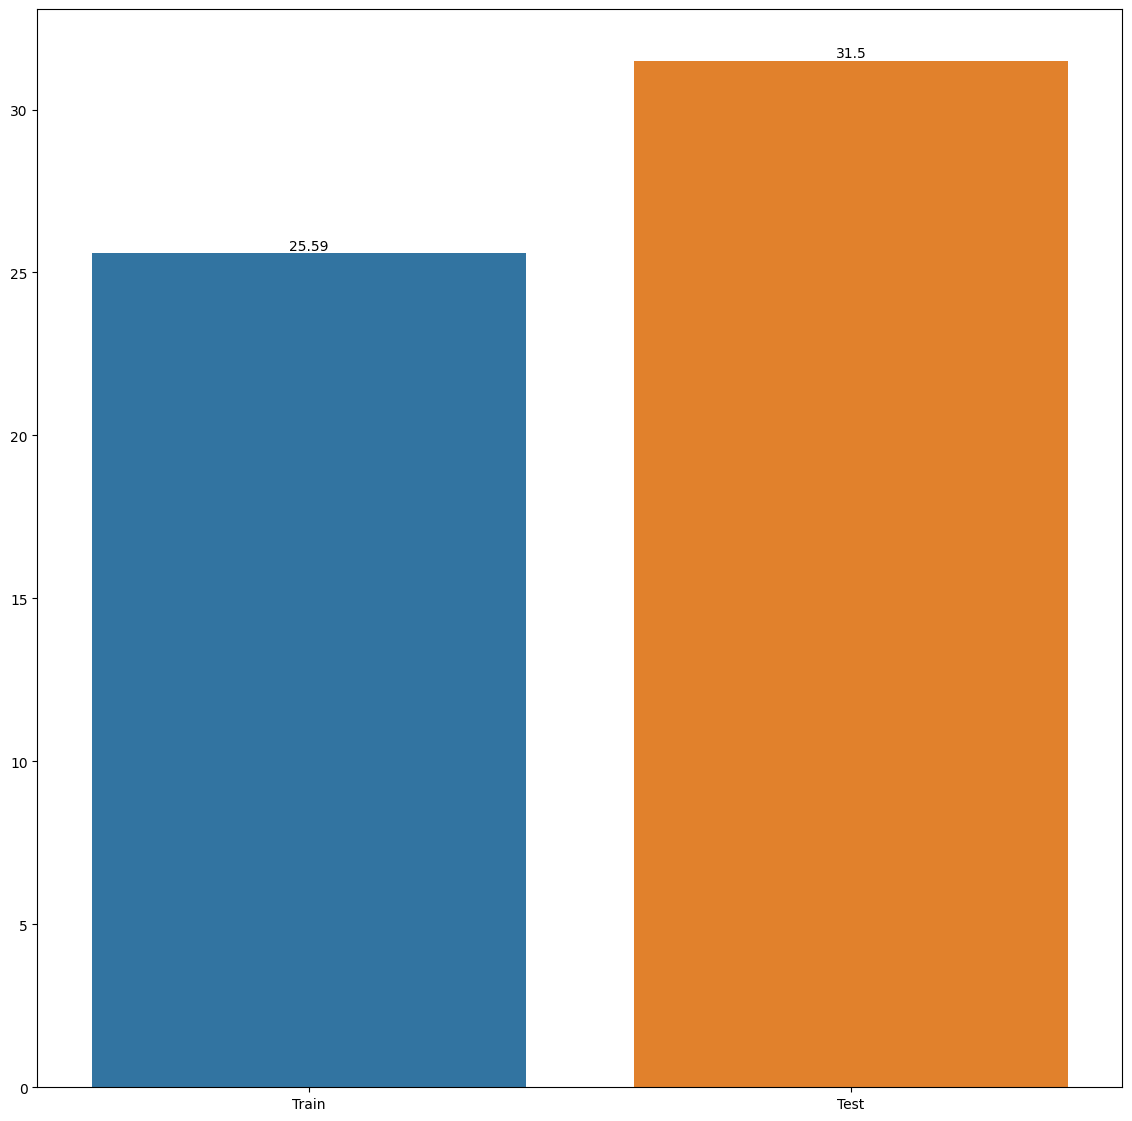

╭─────────────────────────────────────────────── Gini Change test ────────────────────────────────────────────────╮
│ ✅ Test passed with absolute and relative diffs: 5.91 p.p and 23.11%                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

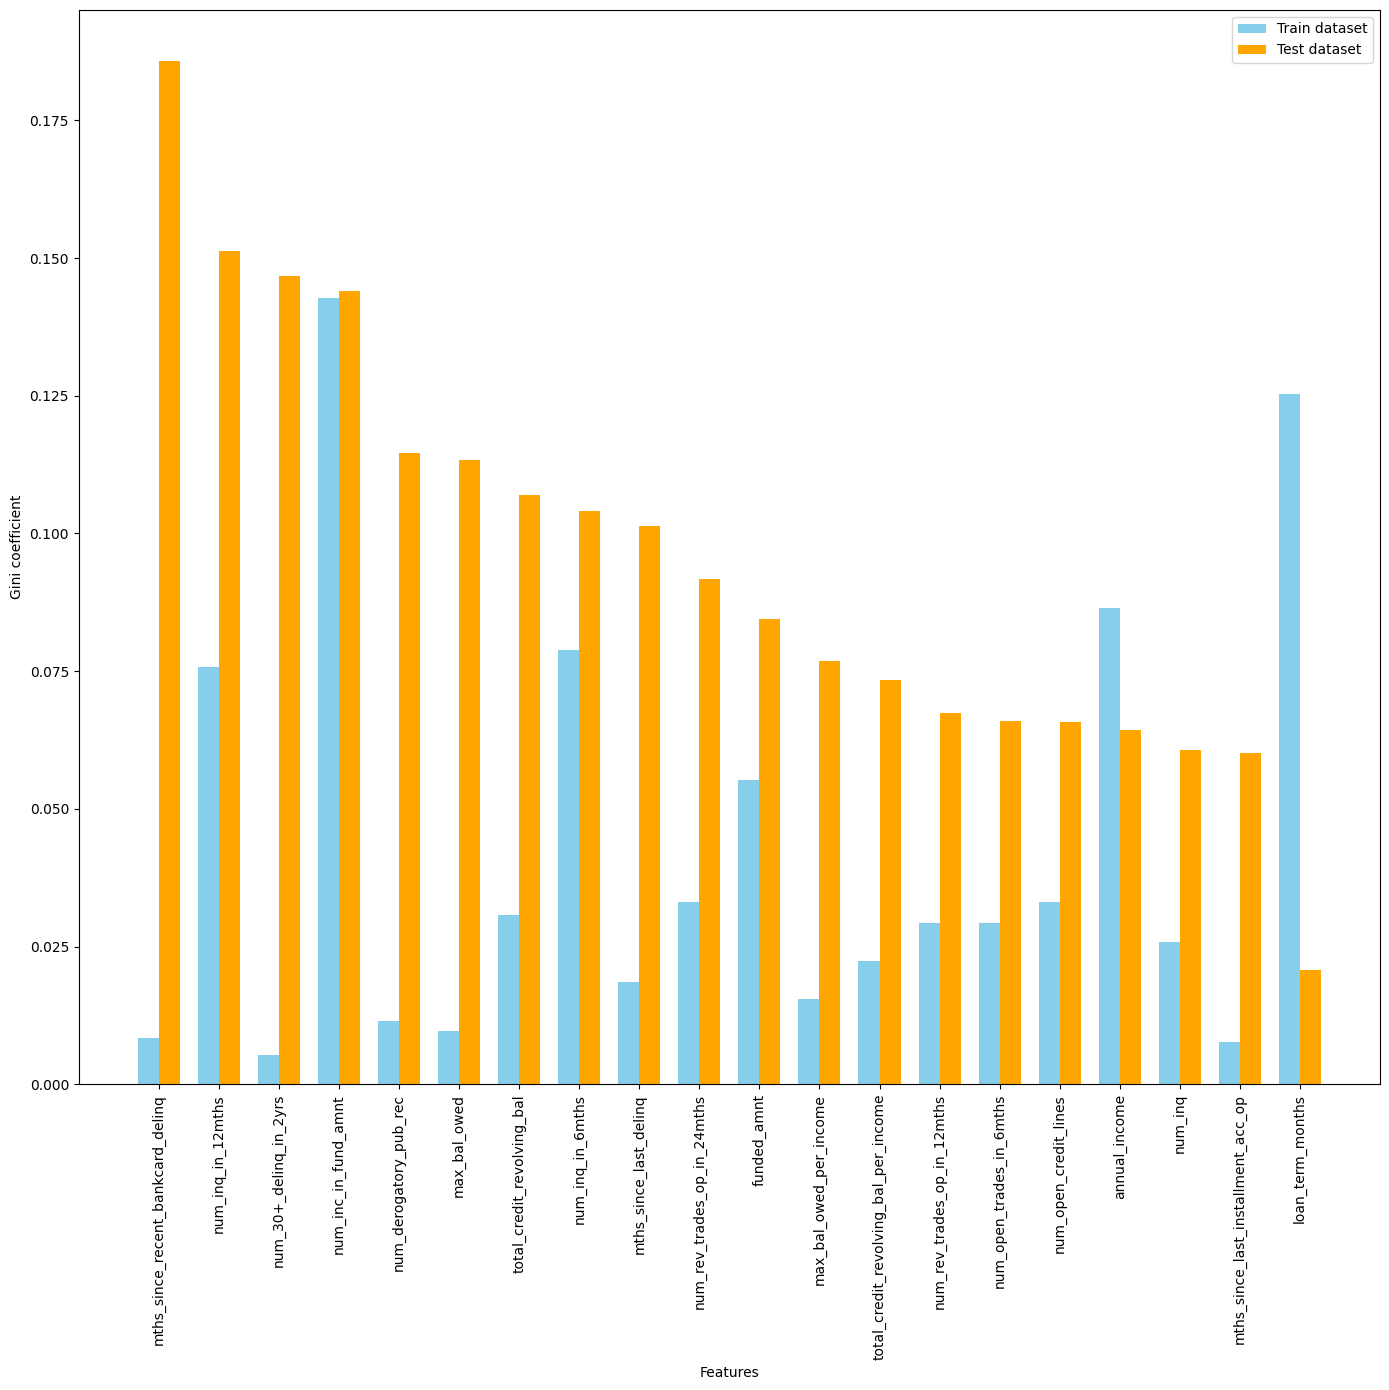

╭─────────────────────────────────────────── Features Gini Change test ───────────────────────────────────────────╮
│ ✅ Test passed with 0.00 , 0.05 , 0.95 shares for red, yellow, green scores                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── Final result ──────────────────────────────────────────────────╮
│ ✅ Validation passed                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [37]:
validator.validate(
    X_val,
    y_val,
    model=final_model.pipeline.named_steps.classifier,
    train_data=[X_train, y_train],
    binner=final_model.pipeline.named_steps.binner
)

# Income calculation 

The calculation of expected profit was performed under the following conditions: 
- Fixed rate for all loans 
- Fixed amount of monthly payments 
- Fixed recovery rate 

In [38]:
def process_results(res):
    res["Optimal Income"]["t"] = round(res["Optimal Income"]["t"], 5)
    res['Optimal Yield']["t"] = round(res['Optimal Yield']["t"], 5)
    res["Optimal Income"]["yield"] = round(res["Optimal Income"]["yield"], 5)
    res['Optimal Yield']["yield"] = round(res['Optimal Yield']["yield"], 5)
    return res

## Recovery rate $= 0\%$

In [39]:
inc_pred = IncomePredictor(
    amount_col="funded_amnt",
    term_month_col="loan_term_months",
    recovery_rate=0,
    interest_rate=0.13,
)

Let's find the optimal t on the test sample and apply it to val 

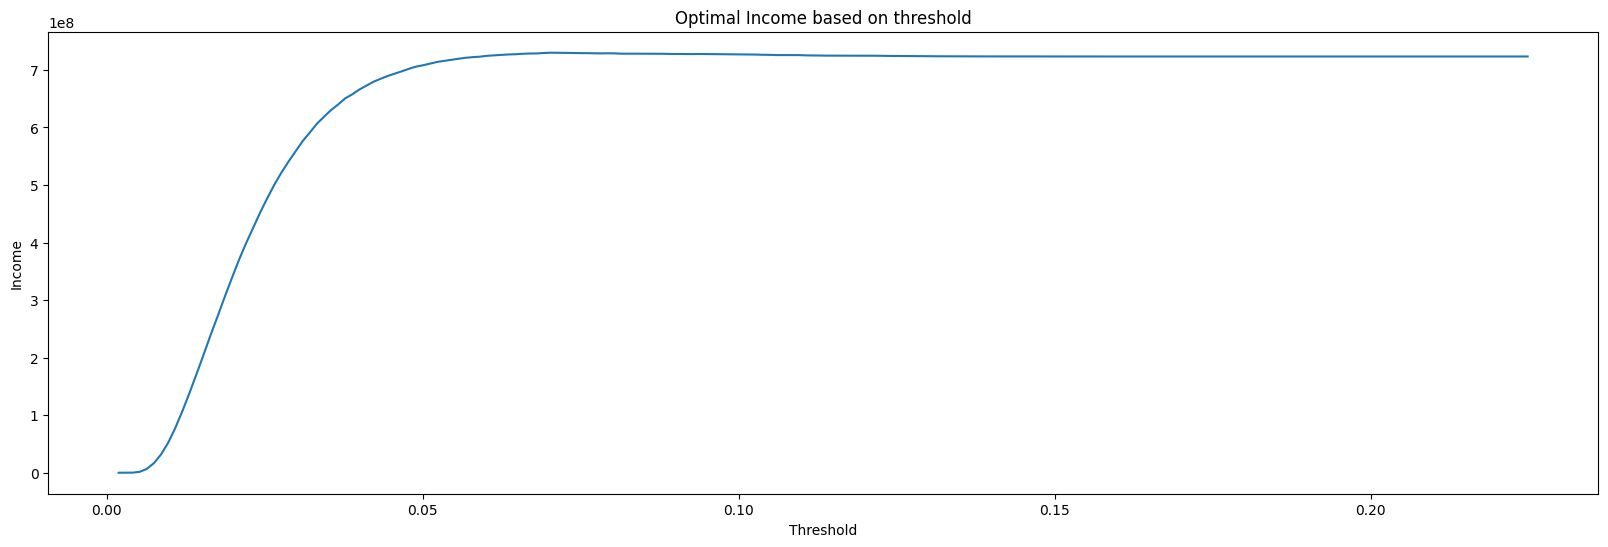

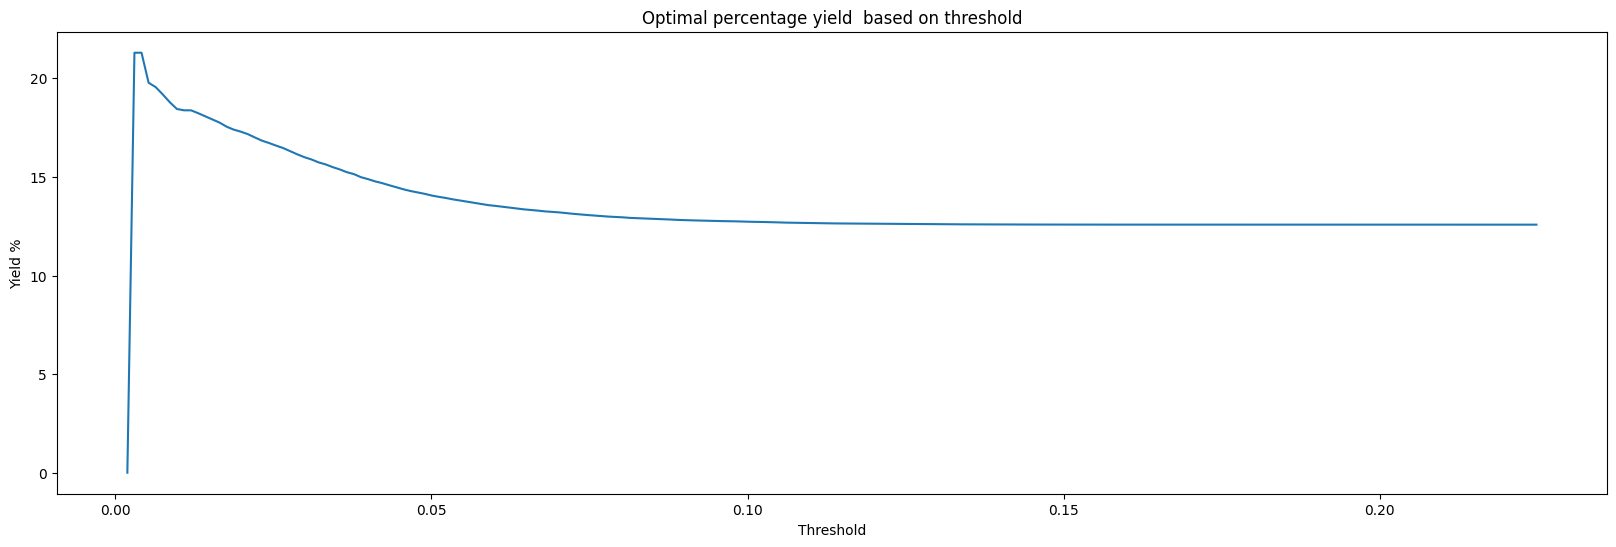

In [40]:
optimal_t_test = inc_pred.find_optimal_t(
    X_test,
    y_test,
    probs=final_model.predict_proba(X_test),
    n_jobs=Config.n_jobs,
    plot=True,
    figsize=(20, 6),

)

In [41]:
process_results(optimal_t_test)

{'Optimal Income': {'t': 0.07022,
  'income': 729903936.0,
  'funded_sum': 5528994000.0,
  'yield': 13.20139},
 'Optimal Yield': {'t': 0.003,
  'income': 761.3955078125,
  'funded_sum': 3575.0,
  'yield': 21.29778}}

In [42]:
val_income = inc_pred.calculate_income(
    X_val, 
    y_val,
    final_model.predict_proba(X_val),
    optimal_t_test["Optimal Income"]["t"]
)

In [43]:
val_income

{'income': 1461104576.0, 'funded_sum': 6274792400.0}

Now let's look at the optimal t on the val sample

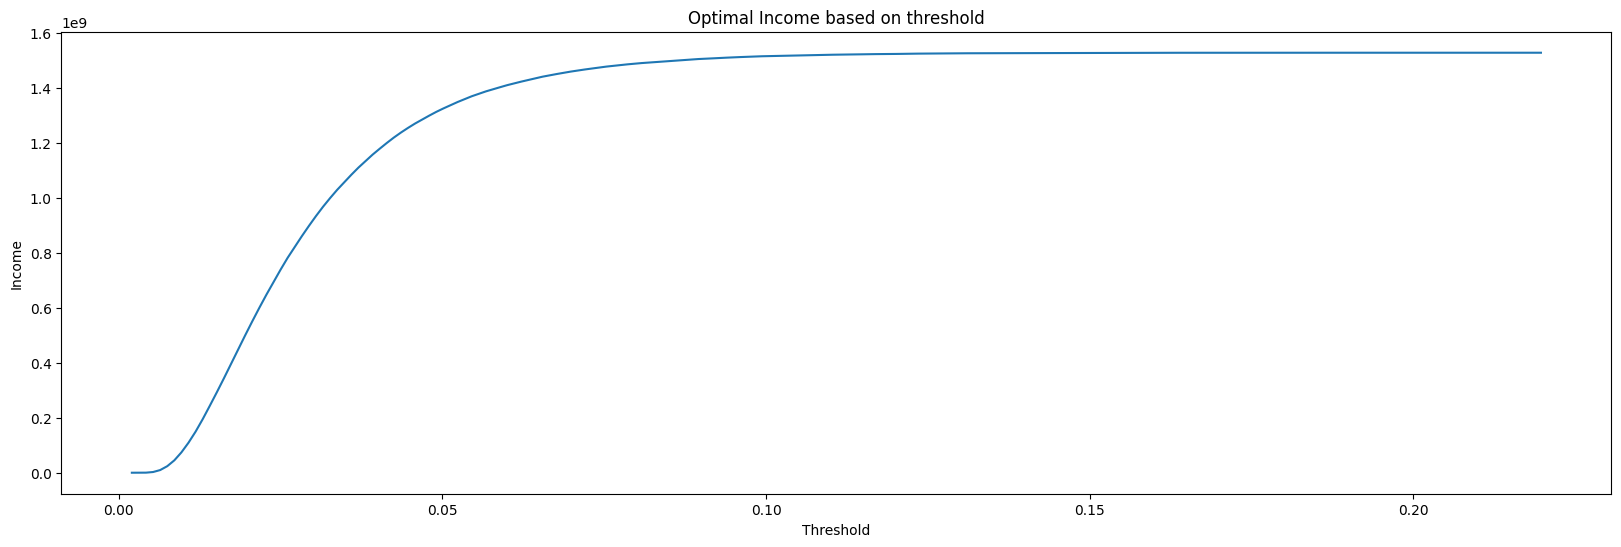

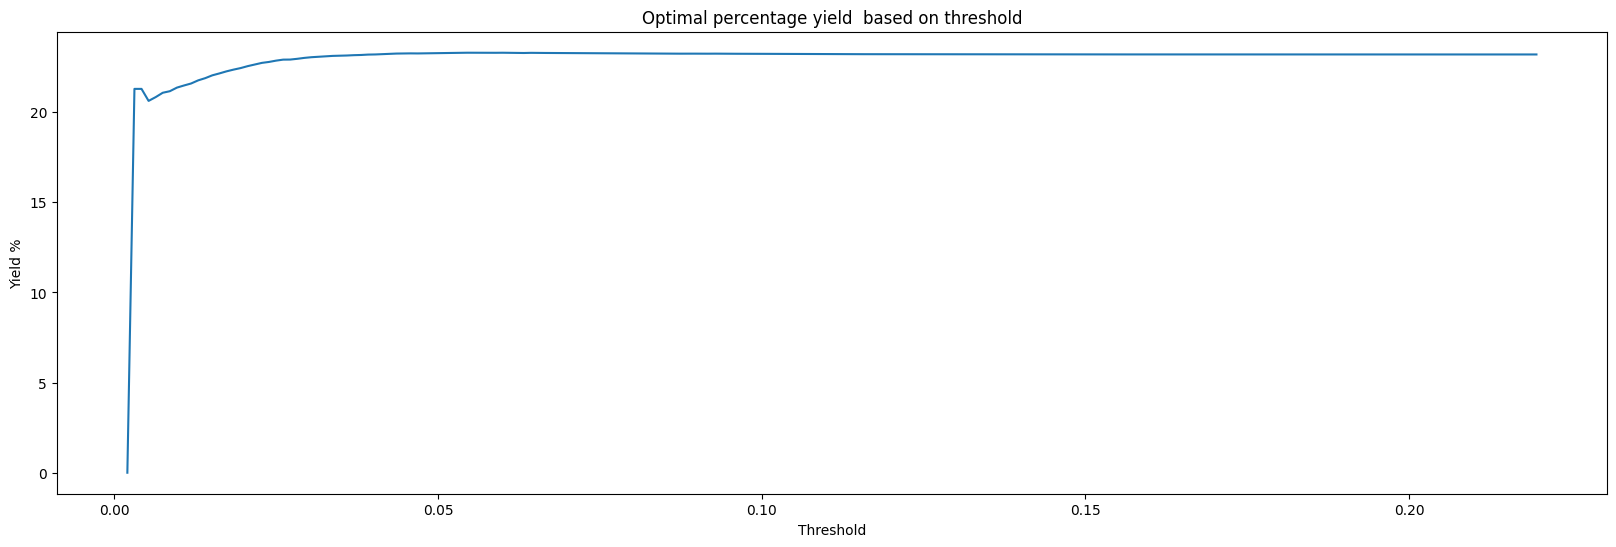

{'Optimal Income': {'t': 0.19672,
  'income': 1528456080.0,
  'funded_sum': 6585660400.0,
  'yield': 23.20885},
 'Optimal Yield': {'t': 0.05452,
  'income': 1370015104.0,
  'funded_sum': 5878802400.0,
  'yield': 23.30432}}

In [44]:
process_results(
    inc_pred.find_optimal_t(
        X_val,
        y_val,
        probs=final_model.predict_proba(X_val),
        n_jobs=Config.n_jobs,
        plot=True,
        figsize=(20, 6),
    )
)

As we can see our threshold is too small, the reason for this is also probably the label shift 

## Recovery rate $= 20\%$ 

In [45]:
inc_pred = IncomePredictor(
    amount_col="funded_amnt",
    term_month_col="loan_term_months",
    recovery_rate=0.2,
    interest_rate=0.13,
)

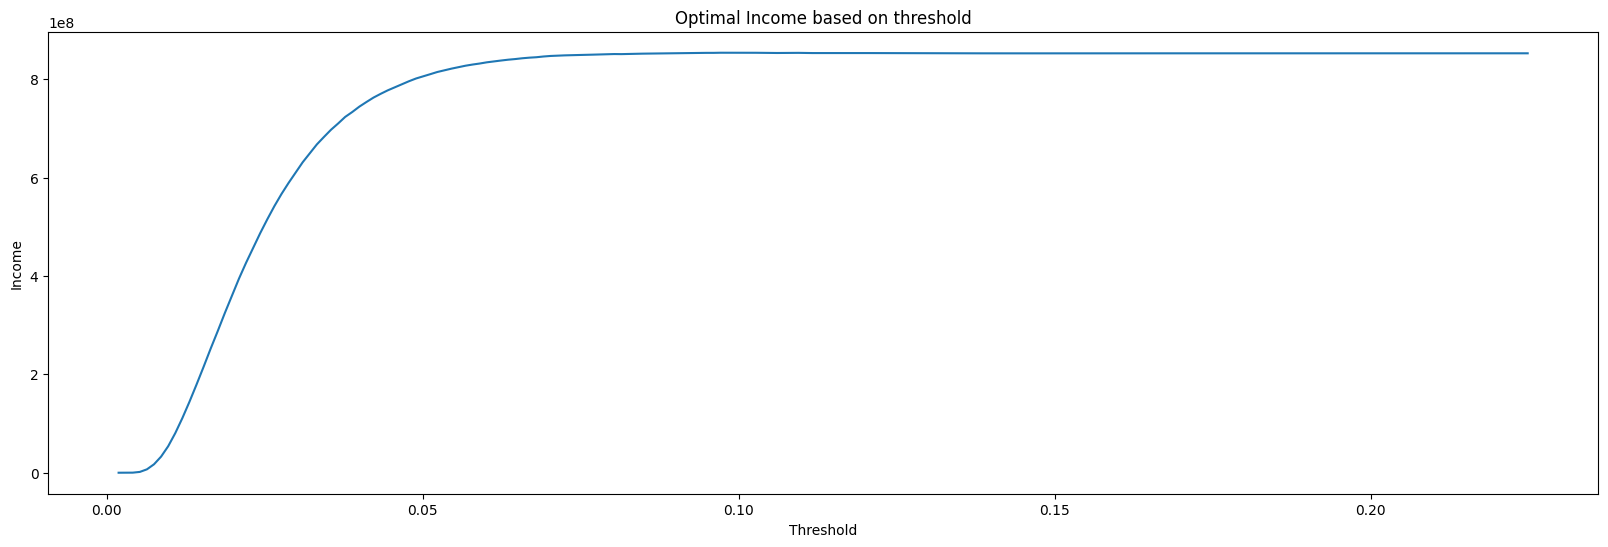

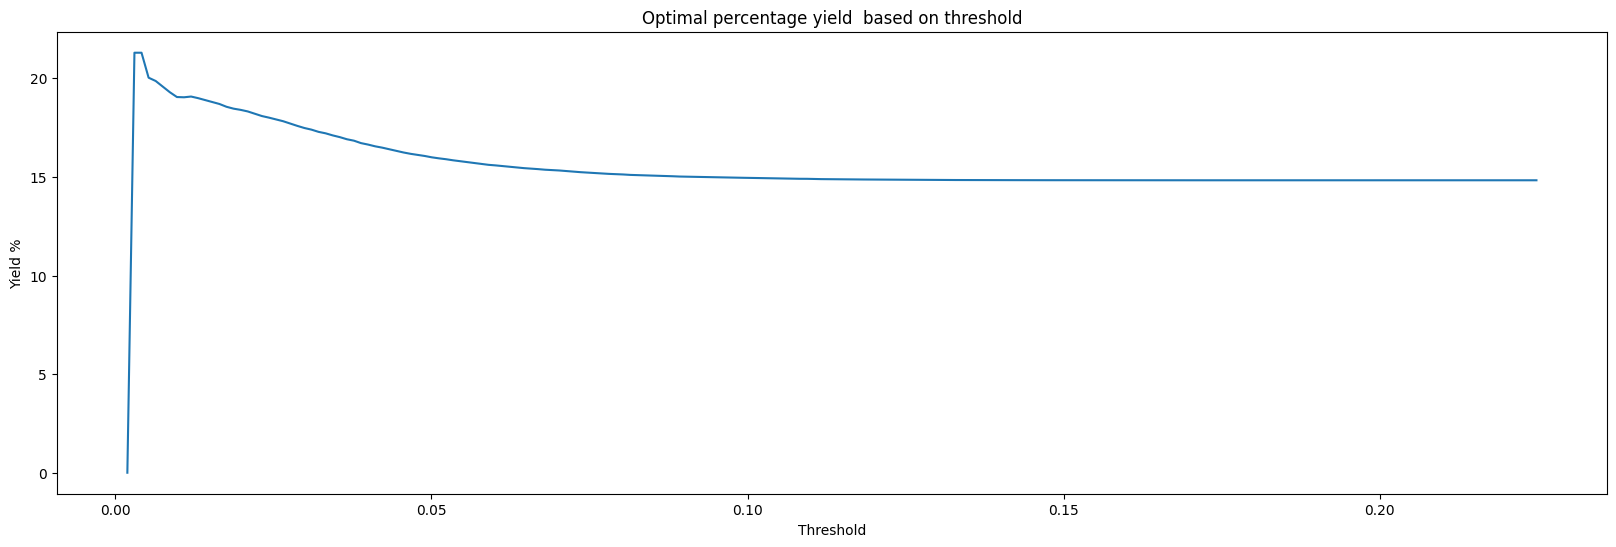

In [46]:
optimal_t_test = inc_pred.find_optimal_t(
    X_test,
    y_test,
    probs=final_model.predict_proba(X_test),
    n_jobs=Config.n_jobs,
    plot=True,
    figsize=(20, 6),

)

In [47]:
process_results(optimal_t_test)

{'Optimal Income': {'t': 0.09823,
  'income': 853962905.5999999,
  'funded_sum': 5706618400.0,
  'yield': 14.96443},
 'Optimal Yield': {'t': 0.003,
  'income': 761.3955078125,
  'funded_sum': 3575.0,
  'yield': 21.29778}}

In [48]:
val_income = inc_pred.calculate_income(
    X_val, 
    y_val,
    final_model.predict_proba(X_val),
    optimal_t_test["Optimal Income"]["t"]
)

In [49]:
val_income

{'income': 1555197516.8, 'funded_sum': 6515734500.0}

Similarly, let's check which value is actually optimal for the val sample

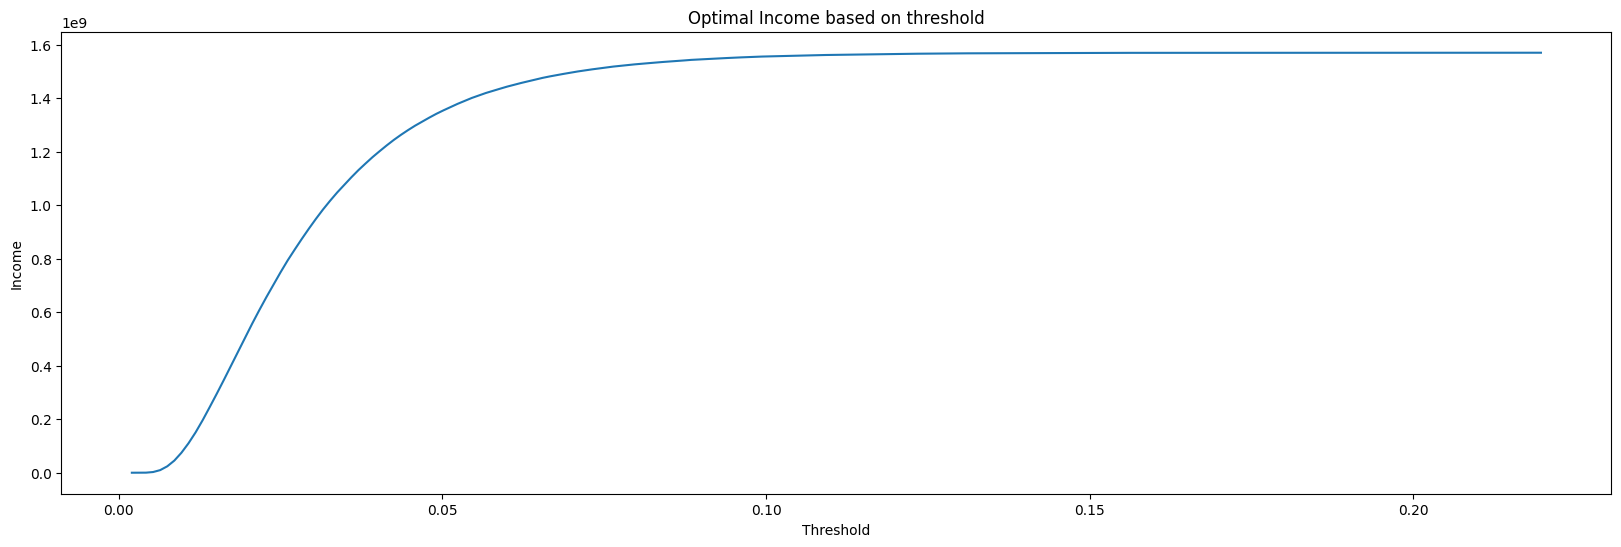

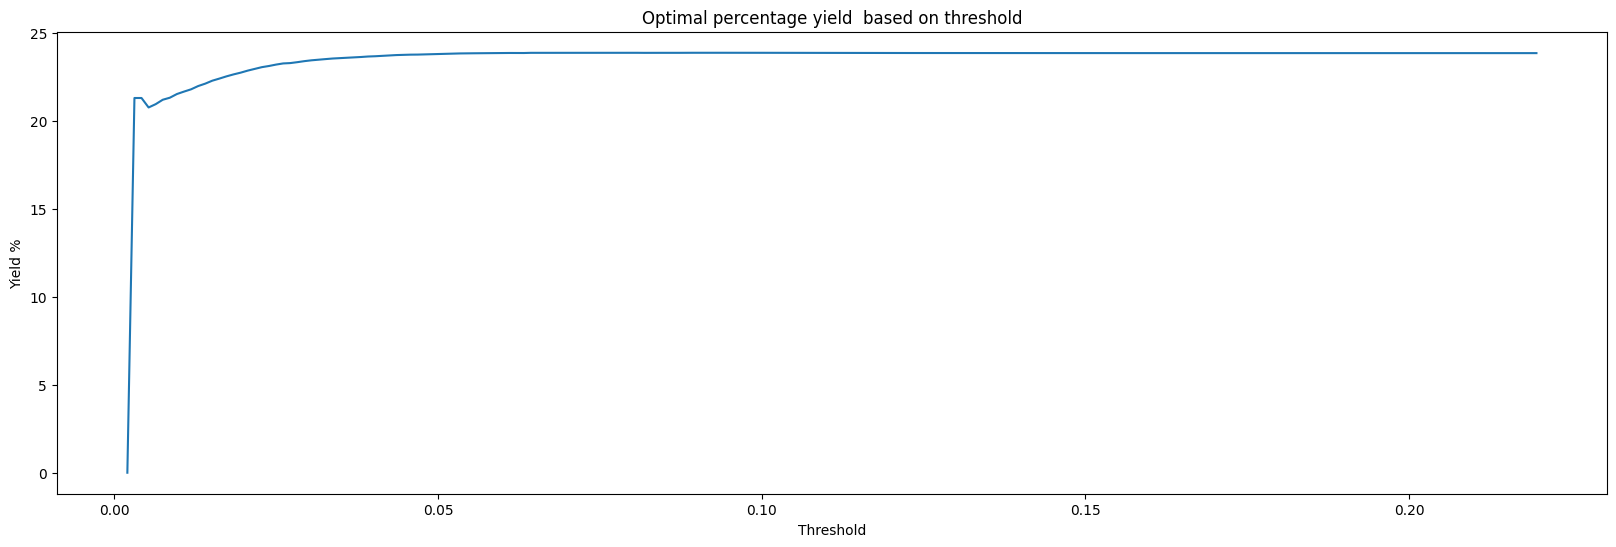

{'Optimal Income': {'t': 0.19672,
  'income': 1570595084.8,
  'funded_sum': 6585660400.0,
  'yield': 23.84871},
 'Optimal Yield': {'t': 0.0764,
  'income': 1518808985.6,
  'funded_sum': 6362569700.0,
  'yield': 23.871}}

In [50]:
process_results(
    inc_pred.find_optimal_t(
        X_val,
        y_val,
        probs=final_model.predict_proba(X_val),
        n_jobs=Config.n_jobs,
        plot=True,
        figsize=(20, 6),
    )
)

# Binning info 

In [51]:
for key, val in final_model.pipeline.named_steps.binner.optb_.items():
    print()
    print("-" * 50)
    print(key)
    print("-" * 50)
    print()
    display(val.binning_table.build())
    print()


--------------------------------------------------
mths_since_recent_bankcard_delinq
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0        (-inf, 31.50)   130902   0.099745     107165   23737    0.181334   
1       [31.50, 56.50)   100574   0.076636      83124   17450    0.173504   
2         [56.50, inf)    84827   0.064637      69121   15706    0.185153   
3              Special        0   0.000000          0       0    0.000000   
4              Missing   996065   0.758983     827376  168689    0.169355   
Totals                  1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0      -0.064962  0.000430  0.000054  
1      -0.011302  0.000010  0.000001  
2       -0.09048  0.000545  0.000068  
3            0.0  0.000000  0.000000  
4       0.017906  0.000242  0.000030  
Totals            0.001227  0.000153



--------------------------------------------------
num_inq_in_12mths
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.50)   603391   0.459773     513759   89632    0.148547   
1       [0.50, 1.50)   342685   0.261120     282074   60611    0.176871   
2       [1.50, 2.50)   169286   0.128993     136501   32785    0.193666   
3       [2.50, 3.50)    88415   0.067371      69887   18528    0.209557   
4        [3.50, inf)   108591   0.082744      84565   24026    0.221252   
5            Special        0   0.000000          0       0    0.000000   
6            Missing        0   0.000000          0       0    0.000000   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.173746  0.013100  0.001635  
1      -0.034603  0.000316  0.000040  
2      -0.145935  0.002880  0.000360  
3        -0.2447  0.004363  0.000544  
4      -0.313912  0.009008  0.001121  
5            0.0  0.000000  0.000000  
6            0.0  0.000000  0.000000  
Totals            0.029666  0.003700



--------------------------------------------------
num_30+_delinq_in_2yrs
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.50)  1051597   0.801297     873071  178526    0.169767   
1       [0.50, 1.50)   172111   0.131145     141838   30273    0.175892   
2        [1.50, inf)    88660   0.067557      71877   16783    0.189296   
3            Special        0   0.000000          0       0    0.000000   
4            Missing        0   0.000000          0       0    0.000000   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.014986  0.000179  0.000022  
1      -0.027867  0.000103  0.000013  
2      -0.117706  0.000972  0.000121  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.001254  0.000157



--------------------------------------------------
num_inc_in_fund_amnt
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0         (-inf, 2.52)   106307   0.081004      79770   26537    0.249626   
1         [2.52, 3.00)   113554   0.086526      86199   27355    0.240899   
2         [3.00, 3.39)   107588   0.081980      84304   23284    0.216418   
3         [3.39, 3.72)    79065   0.060246      63456   15609    0.197420   
4         [3.72, 4.03)    77084   0.058737      62679   14405    0.186874   
5         [4.03, 4.60)   113414   0.086419      93793   19621    0.173003   
6         [4.60, 5.15)   100141   0.076306      83718   16423    0.163999   
7         [5.15, 5.73)    84898   0.064691      71886   13012    0.153266   
8         [5.73, 6.60)   102317   0.077964      87228   15089    0.147473   
9         [6.60, 7.37)    69656   0.053077      59992    9664    0.138739   
10        [7.37, 8.51)    80213   0.061121      69297   10916    0.136088   
11       [8.51, 12.37)   137042   0.104423     119560   17482    0.127567   
12      [12.37, 17.81)    73579   0.056066      64723    8856    0.120360   
13        [17.81, inf)    67510   0.051441      60181    7329    0.108562   
14             Special        0   0.000000          0       0    0.000000   
15             Missing        0   0.000000          0       0    0.000000   
Totals                  1312368   1.000000    1086786  225582    0.171889   

             WoE        IV            JS  
0      -0.471689  0.020867  2.584407e-03  
1      -0.424537  0.017809  2.209523e-03  
2      -0.285633  0.007325  9.125551e-04  
3      -0.169797  0.001835  2.290714e-04  
4      -0.101845  0.000630  7.868363e-05  
5      -0.007806  0.000005  6.599940e-07  
6       0.056475  0.000239  2.985611e-05  
7       0.136913  0.001159  1.447342e-04  
8       0.182263  0.002437  3.042580e-04  
9       0.253507  0.003134  3.906550e-04  
10      0.275876  0.004241  5.284501e-04  
11       0.35035  0.011392  1.416723e-03  
12      0.416725  0.008458  1.049650e-03  
13      0.533221  0.012203  1.507589e-03  
14           0.0  0.000000  0.000000e+00  
15           0.0  0.000000  0.000000e+00  
Totals            0.091733  1.138682e-02



--------------------------------------------------
num_derogatory_pub_rec
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.50)  1095616   0.834839     913325  182291    0.166382   
1        [0.50, inf)   216752   0.165161     173461   43291    0.199726   
2            Special        0   0.000000          0       0    0.000000   
3            Missing        0   0.000000          0       0    0.000000   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.039191  0.001266  0.000158  
1      -0.184288  0.005952  0.000743  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.007218  0.000901



--------------------------------------------------
max_bal_owed
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0          (-inf, 2623.50)   127072   0.096826     102533   24539    0.193111   
1       [2623.50, 3994.50)    78095   0.059507      64119   13976    0.178962   
2       [3994.50, 6019.50)    90257   0.068774      74989   15268    0.169161   
3       [6019.50, 9932.50)    85296   0.064994      72453   12843    0.150570   
4           [9932.50, inf)    65992   0.050285      57687    8305    0.125849   
5                  Special        0   0.000000          0       0    0.000000   
6                  Missing   865656   0.659614     715005  150651    0.174031   
Totals                      1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0      -0.142375  0.002055  0.000257  
1      -0.048897  0.000145  0.000018  
2       0.019286  0.000025  0.000003  
3       0.157843  0.001537  0.000192  
4       0.365878  0.005951  0.000740  
5            0.0  0.000000  0.000000  
6      -0.014973  0.000149  0.000019  
Totals            0.009861  0.001228



--------------------------------------------------
total_credit_revolving_bal
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  \
0            (-inf, 9631.50)   543257   0.413952     445986   97271   
1        [9631.50, 12889.50)   174701   0.133119     143614   31087   
2       [12889.50, 18400.50)   208235   0.158671     171579   36656   
3       [18400.50, 21057.50)    69685   0.053099      57660   12025   
4       [21057.50, 25161.50)    81306   0.061954      67633   13673   
5       [25161.50, 32311.50)    92398   0.070406      77718   14680   
6       [32311.50, 42040.50)    66267   0.050494      56224   10043   
7            [42040.50, inf)    76519   0.058306      66372   10147   
8                    Special        0   0.000000          0       0   
9                    Missing        0   0.000000          0       0   
Totals                        1312368   1.000000    1086786  225582   

        Event rate       WoE        IV            JS  
0         0.179052  -0.04951  0.001031  1.288893e-04  
1         0.177944 -0.041957  0.000238  2.969472e-05  
2         0.176032  -0.02883  0.000133  1.664054e-05  
3         0.172562  -0.00472  0.000001  1.481226e-07  
4         0.168167  0.026377  0.000043  5.341180e-06  
5         0.158878  0.094305  0.000607  7.583600e-05  
6         0.151554  0.150172  0.001083  1.352864e-04  
7         0.132608  0.305801  0.004920  6.126718e-04  
8         0.000000       0.0  0.000000  0.000000e+00  
9         0.000000       0.0  0.000000  0.000000e+00  
Totals    0.171889            0.008057  1.004508e-03



--------------------------------------------------
num_inq_in_6mths
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.50)   759343   0.578605     644647  114696    0.151046   
1       [0.50, 1.50)   352618   0.268688     286918   65700    0.186321   
2       [1.50, 2.50)   129788   0.098896     101964   27824    0.214380   
3        [2.50, inf)    70619   0.053810      53257   17362    0.245855   
4            Special        0   0.000000          0       0    0.000000   
5            Missing        0   0.000000          0       0    0.000000   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.154121  0.013058  0.001631  
1      -0.098199  0.002675  0.000334  
2      -0.273575  0.008076  0.001006  
3      -0.451451  0.012623  0.001565  
4            0.0  0.000000  0.000000  
5            0.0  0.000000  0.000000  
Totals            0.036432  0.004536



--------------------------------------------------
mths_since_last_delinq
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0         (-inf, 7.50)    67727   0.051607      55345   12382    0.182822   
1        [7.50, 17.50)   122248   0.093151     100072   22176    0.181402   
2       [17.50, 33.50)   167442   0.127588     138054   29388    0.175512   
3       [33.50, 41.50)    72073   0.054918      59732   12341    0.171229   
4       [41.50, 50.50)    69972   0.053317      58037   11935    0.170568   
5         [50.50, inf)   158087   0.120459     129759   28328    0.179192   
6              Special        0   0.000000          0       0    0.000000   
7              Missing   654819   0.498960     545787  109032    0.166507   
Totals                  1312368   1.000000    1086786  225582    0.171889   

             WoE        IV            JS  
0      -0.074954  0.000297  3.712848e-05  
1      -0.065417  0.000407  5.089375e-05  
2      -0.025238  0.000082  1.024230e-05  
3       0.004645  0.000001  1.478617e-07  
4       0.009309  0.000005  5.758048e-07  
5      -0.050468  0.000312  3.898489e-05  
6            0.0  0.000000  0.000000e+00  
7       0.038291  0.000722  9.029635e-05  
Totals            0.001826  2.282694e-04



--------------------------------------------------
num_rev_trades_op_in_24mths
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 1.50)   152836   0.116458     133344   19492    0.127535   
1       [1.50, 2.50)    85842   0.065410      72685   13157    0.153270   
2       [2.50, 4.50)   114822   0.087492      93773   21049    0.183319   
3        [4.50, inf)    93212   0.071026      71979   21233    0.227793   
4            Special        0   0.000000          0       0    0.000000   
5            Missing   865656   0.659614     715005  150651    0.174031   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.350632  0.012724  0.001582  
1       0.136885  0.001171  0.000146  
2      -0.078272  0.000550  0.000069  
3      -0.351478  0.009804  0.001219  
4            0.0  0.000000  0.000000  
5      -0.014973  0.000149  0.000019  
Totals            0.024398  0.003035



--------------------------------------------------
funded_amnt
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  \
0            (-inf, 3512.50)    68089   0.051883      58980    9109   
1         [3512.50, 7012.50)   205658   0.156708     175481   30177   
2         [7012.50, 9012.50)   116581   0.088833      98580   18001   
3        [9012.50, 10012.50)   120768   0.092023     101060   19708   
4       [10012.50, 12012.50)   129799   0.098904     106811   22988   
5       [12012.50, 15012.50)   156221   0.119037     128103   28118   
6       [15012.50, 28012.50)   399867   0.304691     324994   74873   
7            [28012.50, inf)   115385   0.087921      92777   22608   
8                    Special        0   0.000000          0       0   
9                    Missing        0   0.000000          0       0   
Totals                        1312368   1.000000    1086786  225582   

        Event rate       WoE        IV        JS  
0         0.133781  0.295639  0.004106  0.000511  
1         0.146734  0.188154  0.005211  0.000650  
2         0.154408  0.128145  0.001398  0.000175  
3         0.163189  0.062393  0.000351  0.000044  
4         0.177105 -0.036208  0.000131  0.000016  
5         0.179989 -0.055872  0.000378  0.000047  
6         0.187245 -0.104283  0.003428  0.000428  
7         0.195935 -0.160401  0.002382  0.000297  
8         0.000000       0.0  0.000000  0.000000  
9         0.000000       0.0  0.000000  0.000000  
Totals    0.171889            0.017386  0.002170



--------------------------------------------------
max_bal_owed_per_income
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.04)   118854   0.090565      97438   21416    0.180187   
1       [0.04, 0.06)    97248   0.074101      80879   16369    0.168322   
2       [0.06, 0.09)    74629   0.056866      62487   12142    0.162698   
3       [0.09, 0.13)    77606   0.059134      65341   12265    0.158042   
4        [0.13, inf)    78375   0.059720      65636   12739    0.162539   
5            Special        0   0.000000          0       0    0.000000   
6            Missing   865656   0.659614     715005  150651    0.174031   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0      -0.057218  0.000302  0.000038  
1       0.025269  0.000047  0.000006  
2       0.065992  0.000242  0.000030  
3       0.100574  0.000579  0.000072  
4        0.06716  0.000263  0.000033  
5            0.0  0.000000  0.000000  
6      -0.014973  0.000149  0.000019  
Totals            0.001582  0.000198



--------------------------------------------------
total_credit_revolving_bal_per_income
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.03)    66625   0.050767      55279   11346    0.170296   
1       [0.03, 0.07)   109852   0.083705      91490   18362    0.167152   
2       [0.07, 0.11)   188735   0.143813     157801   30934    0.163902   
3       [0.11, 0.13)    65757   0.050106      55218   10539    0.160272   
4       [0.13, 0.19)   227821   0.173595     190015   37806    0.165946   
5       [0.19, 0.22)    93349   0.071130      77502   15847    0.169761   
6       [0.22, 0.25)   102040   0.077753      84480   17560    0.172089   
7       [0.25, 0.32)   155524   0.118506     128123   27401    0.176185   
8       [0.32, 0.40)   119613   0.091143      97700   21913    0.183199   
9        [0.40, inf)   183052   0.139482     149178   33874    0.185051   
10           Special        0   0.000000          0       0    0.000000   
11           Missing        0   0.000000          0       0    0.000000   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE            IV            JS  
0       0.011232  6.380578e-06  7.975680e-07  
1        0.03365  9.373801e-05  1.171670e-05  
2       0.057183  4.614613e-04  5.767480e-05  
3        0.08391  3.431399e-04  4.287991e-05  
4       0.042339  3.068755e-04  3.835658e-05  
5       0.015027  1.598343e-05  1.997910e-06  
6      -0.001405  1.535639e-07  1.919548e-08  
7      -0.029885  1.068799e-04  1.335950e-05  
8      -0.077475  5.610521e-04  7.011398e-05  
9      -0.089804  1.158235e-03  1.447308e-04  
10           0.0  0.000000e+00  0.000000e+00  
11           0.0  0.000000e+00  0.000000e+00  
Totals            3.053900e-03  3.816469e-04



--------------------------------------------------
num_rev_trades_op_in_12mths
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.50)   151047   0.115095     130248   20799    0.137699   
1       [0.50, 1.50)   134293   0.102329     112882   21411    0.159435   
2       [1.50, 2.50)    81365   0.061999      66260   15105    0.185645   
3        [2.50, inf)    80007   0.060964      62391   17616    0.220181   
4            Special        0   0.000000          0       0    0.000000   
5            Missing   865656   0.659614     715005  150651    0.174031   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.262239  0.007250  0.000904  
1       0.090142  0.000807  0.000101  
2      -0.093736  0.000562  0.000070  
3      -0.307683  0.006364  0.000792  
4            0.0  0.000000  0.000000  
5      -0.014973  0.000149  0.000019  
Totals            0.015131  0.001886



--------------------------------------------------
num_open_trades_in_6mths
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.50)   188691   0.143779     162262   26429    0.140065   
1       [0.50, 1.50)   141183   0.107579     117573   23610    0.167230   
2        [1.50, inf)   116838   0.089028      91946   24892    0.213047   
3            Special        0   0.000000          0       0    0.000000   
4            Missing   865656   0.659614     715005  150651    0.174031   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.242454  0.007794  0.000972  
1       0.033093  0.000117  0.000015  
2      -0.265641  0.006838  0.000852  
3            0.0  0.000000  0.000000  
4      -0.014973  0.000149  0.000019  
Totals            0.014897  0.001857



--------------------------------------------------
num_open_credit_lines
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0         (-inf, 5.50)   113237   0.086284      95957   17280    0.152600   
1         [5.50, 6.50)    82295   0.062707      69241   13054    0.158624   
2         [6.50, 7.50)    99671   0.075947      83477   16194    0.162475   
3         [7.50, 8.50)   111306   0.084813      93012   18294    0.164358   
4         [8.50, 9.50)   116628   0.088868      96929   19699    0.168905   
5        [9.50, 10.50)   113928   0.086811      94364   19564    0.171722   
6       [10.50, 11.50)   105176   0.080142      86794   18382    0.174774   
7       [11.50, 12.50)    94408   0.071937      77738   16670    0.176574   
8       [12.50, 13.50)    82633   0.062965      68006   14627    0.177012   
9       [13.50, 15.50)   129360   0.098570     106310   23050    0.178185   
10      [15.50, 18.50)   124380   0.094775     101938   22442    0.180431   
11      [18.50, 21.50)    67768   0.051638      55374   12394    0.182889   
12        [21.50, inf)    71578   0.054541      57646   13932    0.194641   
13             Special        0   0.000000          0       0    0.000000   
14             Missing        0   0.000000          0       0    0.000000   
Totals                  1312368   1.000000    1086786  225582    0.171889   

             WoE            IV            JS  
0       0.142054  1.660959e-03  2.074455e-04  
1       0.096202  5.621700e-04  7.024416e-05  
2       0.067634  3.397427e-04  4.245974e-05  
3       0.053859  2.416966e-04  3.020842e-05  
4       0.021115  3.934586e-05  4.918141e-06  
5       0.001172  1.192443e-07  1.490553e-08  
6      -0.020131  3.269203e-05  4.086435e-06  
7      -0.032563  7.709425e-05  9.636355e-06  
8      -0.035569  8.059435e-05  1.007376e-05  
9      -0.043603  1.900899e-04  2.375936e-05  
10     -0.058866  3.347817e-04  4.184167e-05  
11     -0.075399  3.008595e-04  3.759853e-05  
12     -0.152164  1.326504e-03  1.656532e-04  
13           0.0  0.000000e+00  0.000000e+00  
14           0.0  0.000000e+00  0.000000e+00  
Totals            5.186649e-03  6.479401e-04



--------------------------------------------------
annual_income
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  \
0             (-inf, 28624.43)    66087   0.050357      51879   14208   
1         [28624.43, 37114.50)   107590   0.081982      85327   22263   
2         [37114.50, 45639.28)   147973   0.112753     118911   29062   
3         [45639.28, 50963.50)    98024   0.074692      79572   18452   
4         [50963.50, 60948.50)   180321   0.137401     147103   33218   
5         [60948.50, 65974.50)    79050   0.060235      65107   13943   
6         [65974.50, 70016.50)    70137   0.053443      58126   12011   
7         [70016.50, 75030.00)    71405   0.054409      59474   11931   
8         [75030.00, 85794.00)   115005   0.087632      96422   18583   
9        [85794.00, 100237.68)   130933   0.099769     111290   19643   
10      [100237.68, 125420.00)   116267   0.088593     100185   16082   
11            [125420.00, inf)   129576   0.098735     113390   16186   
12                     Special        0   0.000000          0       0   
13                     Missing        0   0.000000          0       0   
Totals                          1312368   1.000000    1086786  225582   

        Event rate       WoE        IV            JS  
0         0.214989 -0.277187  0.004226  5.266197e-04  
1         0.206924 -0.228731  0.004615  5.756700e-04  
2         0.196401 -0.163352  0.003172  3.960144e-04  
3         0.188240 -0.110807  0.000951  1.187737e-04  
4         0.184216 -0.084255  0.001003  1.252784e-04  
5         0.176382 -0.031242  0.000059  7.424196e-06  
6         0.171251  0.004494  0.000001  1.347126e-07  
7         0.167089  0.034103  0.000063  7.821156e-06  
8         0.161584  0.074191  0.000471  5.882115e-05  
9         0.150023  0.162122  0.002485  3.102433e-04  
10        0.138320  0.257022  0.005370  6.694189e-04  
11        0.124915   0.37439  0.012199  1.516001e-03  
12        0.000000       0.0  0.000000  0.000000e+00  
13        0.000000       0.0  0.000000  0.000000e+00  
Totals    0.171889            0.034614  4.312220e-03



--------------------------------------------------
num_inq
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 0.50)   237968   0.181327     202280   35688    0.149970   
1       [0.50, 1.50)   104251   0.079437      86293   17958    0.172257   
2        [1.50, inf)   104493   0.079622      83208   21285    0.203698   
3            Special        0   0.000000          0       0    0.000000   
4            Missing   865656   0.659614     715005  150651    0.174031   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE            IV            JS  
0       0.162542  4.538613e-03  5.667029e-04  
1      -0.002583  5.306444e-07  6.633053e-08  
2      -0.208955  3.717851e-03  4.638878e-04  
3            0.0  0.000000e+00  0.000000e+00  
4      -0.014973  1.485993e-04  1.857474e-05  
Totals            8.405594e-03  1.049232e-03



--------------------------------------------------
mths_since_last_installment_acc_op
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0         (-inf, 4.50)    66672   0.050803      52287   14385    0.215758   
1        [4.50, 11.50)   130780   0.099652     106120   24660    0.188561   
2       [11.50, 21.50)   115035   0.087655      97347   17688    0.153762   
3         [21.50, inf)   122152   0.093078     105967   16185    0.132499   
4              Special        0   0.000000          0       0    0.000000   
5              Missing   877729   0.668813     725065  152664    0.173931   
Totals                  1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0      -0.281734  0.004411  0.000550  
1      -0.112908  0.001318  0.000165  
2       0.133099  0.001486  0.000186  
3       0.306747  0.007901  0.000984  
4            0.0  0.000000  0.000000  
5      -0.014274  0.000137  0.000017  
Totals            0.015252  0.001901



--------------------------------------------------
loan_term_months
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 48.00)   939066   0.715551     804399  134667    0.143405   
1        [48.00, inf)   373302   0.284449     282387   90915    0.243543   
2             Special        0   0.000000          0       0    0.000000   
3             Missing        0   0.000000          0       0    0.000000   
Totals                 1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.214994  0.030784  0.003841  
1      -0.438943  0.062851  0.007794  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.093636  0.011635



--------------------------------------------------
emp_length
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  \
0                       [10+ years]   438402   0.334054     367661   70741   
1       [2 years, 6 years, 4 years]   256669   0.195577     213016   43653   
2                         [5 years]    81627   0.062198      67679   13948   
3                         [3 years]   104054   0.079287      86181   17873   
4                [7 years, 9 years]   109663   0.083561      90673   18990   
5                         [8 years]    62331   0.047495      51413   10918   
6                [< 1 year, 1 year]   187508   0.142878     154303   33205   
7                           Special        0   0.000000          0       0   
8                           Missing    72114   0.054950      55860   16254   
Totals                               1312368   1.000000    1086786  225582   

        Event rate       WoE            IV            JS  
0         0.161361   0.07584  1.873841e-03  2.341740e-04  
1         0.170075  0.012799  3.190394e-05  3.987965e-06  
2         0.170875  0.007144  3.166556e-06  3.958186e-07  
3         0.171767  0.000862  5.893482e-08  7.366853e-09  
4         0.173167 -0.008949  6.711870e-06  8.389809e-07  
5         0.175162 -0.022818  2.491430e-05  3.114221e-06  
6         0.177086 -0.036079  1.881854e-04  2.352190e-05  
7         0.000000       0.0  0.000000e+00  0.000000e+00  
8         0.225393 -0.337787  6.976768e-03  8.679734e-04  
Totals    0.171889            9.105550e-03  1.134014e-03



--------------------------------------------------
home_ownership_status
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0         [MORTGAGE]   648632   0.494246     551623   97009    0.149559   
1       [OWN, OTHER]   140166   0.106804     115683   24483    0.174671   
2             [RENT]   523570   0.398951     419480  104090    0.198808   
3            Special        0   0.000000          0       0    0.000000   
4            Missing        0   0.000000          0       0    0.000000   
Totals                1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.165765  0.012852  0.001605  
1      -0.019422  0.000041  0.000005  
2      -0.178536  0.013470  0.001682  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.026363  0.003291



--------------------------------------------------
verification_status
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate  \
0          [Not Verified]   384205   0.292757     335448   48757    0.126904   
1       [Source Verified]   515473   0.392781     423353   92120    0.178710   
2              [Verified]   412690   0.314462     327985   84705    0.205251   
3                 Special        0   0.000000          0       0    0.000000   
4                 Missing        0   0.000000          0       0    0.000000   
Totals                     1312368   1.000000    1086786  225582    0.171889   

             WoE        IV        JS  
0       0.356322  0.032968  0.004099  
1      -0.047182  0.000888  0.000111  
2      -0.218503  0.016104  0.002009  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.049960  0.006219



--------------------------------------------------
loan_purpose
--------------------------------------------------



Bin    Count  Count (%)  \
0                             [wedding, car, credit_card]   311998   0.237737   
1                                      [home_improvement]    82467   0.062838   
2                                        [major_purchase]    27583   0.021018   
3                                       [vacation, other]    78956   0.060163   
4                                    [debt_consolidation]   766787   0.584277   
5                                       [medical, moving]    22498   0.017143   
6       [house, educational, renewable_energy, small_b...    22079   0.016824   
7                                                 Special        0   0.000000   
8                                                 Missing        0   0.000000   
Totals                                                     1312368   1.000000   

        Non-event   Event  Event rate       WoE        IV        JS  
0          267062   44936    0.144027  0.209945  0.009770  0.001219  
1           69959   12508    0.151673  0.149245  0.001332  0.000166  
2           23303    4280    0.155168  0.122333  0.000302  0.000038  
3           64900   14056    0.178023 -0.042498  0.000110  0.000014  
4          626575  140212    0.182857 -0.075183  0.003385  0.000423  
5           18192    4306    0.191395 -0.131324  0.000308  0.000039  
6           16795    5284    0.239322 -0.415898  0.003315  0.000411  
7               0       0    0.000000       0.0  0.000000  0.000000  
8               0       0    0.000000       0.0  0.000000  0.000000  
Totals    1086786  225582    0.171889            0.018522  0.002310



--------------------------------------------------
addr_state
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  \
0           [ME, VT, DC, NH]    14322   0.010913      12618    1704   
1                       [OR]    15444   0.011768      13436    2008   
2               [CO, SC, KS]    54766   0.041731      47083    7683   
3       [WA, WV, CT, MT, WY]    59532   0.045362      50939    8593   
4                   [ID, IL]    53959   0.041116      45760    8199   
5                   [WI, RI]    22895   0.017446      19375    3520   
6                       [GA]    43292   0.032988      36443    6849   
7               [MA, UT, ND]    40774   0.031069      34202    6572   
8                   [DE, TX]   111036   0.084607      92279   18757   
9                   [AK, MN]    26652   0.020308      22088    4564   
10          [MI, CA, AZ, VA]   289060   0.220258     239135   49925   
11                  [OH, PA]    89769   0.068402      73871   15898   
12                  [NJ, NC]    85687   0.065292      70360   15327   
13      [MD, KY, IN, MO, HI]    92215   0.070266      75532   16683   
14                  [TN, SD]    22606   0.017225      18444    4162   
15              [FL, NY, NM]   208345   0.158755     169688   38657   
16                      [LA]    15441   0.011766      12425    3016   
17                      [NV]    18454   0.014062      14806    3648   
18                  [OK, NE]    15204   0.011585      12132    3072   
19          [AR, AL, MS, IA]    32915   0.025081      26170    6745   
20                   Special        0   0.000000          0       0   
21                   Missing        0   0.000000          0       0   
Totals                        1312368   1.000000    1086786  225582   

        Event rate       WoE            IV            JS  
0         0.118978   0.42985  1.743723e-03  2.163026e-04  
1         0.130018  0.328502  1.137156e-03  1.415088e-04  
2         0.140288  0.240606  2.229112e-03  2.779688e-04  
3         0.144343  0.207385  1.820558e-03  2.271629e-04  
4         0.151949  0.147102  8.472805e-04  1.058147e-04  
5         0.153745  0.133226  2.962574e-04  3.700481e-05  
6         0.158205   0.09935  3.150757e-04  3.936827e-05  
7         0.161181   0.07717  1.803645e-04  2.253998e-05  
8         0.168927  0.020953  3.689116e-05  4.611310e-06  
9         0.171244  0.004539  4.177387e-07  5.221729e-08  
10        0.172715  -0.00579  7.397740e-06  9.247162e-07  
11        0.177099 -0.036169  9.054964e-05  1.131809e-05  
12        0.178872 -0.048287  1.546592e-04  1.933052e-05  
13        0.180914  -0.06213  2.767912e-04  3.459333e-05  
14        0.184110 -0.083553  1.235673e-04  1.544142e-05  
15        0.185543 -0.093063  1.417174e-03  1.770829e-04  
16        0.195324 -0.156517  3.031843e-04  3.785940e-05  
17        0.197681 -0.171443  4.368099e-04  5.453447e-05  
18        0.202052 -0.198778  4.879846e-04  6.089785e-05  
19        0.204922 -0.216484  1.259993e-03  1.571923e-04  
20        0.000000       0.0  0.000000e+00  0.000000e+00  
21        0.000000       0.0  0.000000e+00  0.000000e+00  
Totals    0.171889            1.316495e-02  1.641509e-03



--------------------------------------------------
initial_list_status
--------------------------------------------------



Bin    Count  Count (%)  Non-event   Event  Event rate       WoE  \
0           [w]   756819   0.576682     630787  126032    0.166529  0.038136   
1           [f]   555549   0.423318     455999   99550    0.179192 -0.050466   
2       Special        0   0.000000          0       0    0.000000       0.0   
3       Missing        0   0.000000          0       0    0.000000       0.0   
Totals           1312368   1.000000    1086786  225582    0.171889             

              IV        JS  
0       0.000828  0.000104  
1       0.001096  0.000137  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.001924  0.000241